In [5]:
!pip uninstall -y monai
!pip -q install monai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.1+cu121 requires torch==2.3.1, but you have torch 2.9.0 which is incompatible.
torchvision 0.18.1+cu121 requires torch==2.3.1, but you have torch 2.9.0 which is incompatible.


In [2]:
!pip uninstall -y transformers
!pip -q install git+https://github.com/huggingface/transformers

In [1]:
!pip -q install nibabel accelerate umap-learn

In [1]:
%%bash
set -a
source .env
set +a

hf auth login --token $HF_TOKEN --add-to-git-credential

Token is valid (permission: write).
The token `collab` has been saved to /home/jovyan/.cache/huggingface/stored_tokens
Token has not been saved to git credential helper.
Your token has been saved to /home/jovyan/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [3]:
from pathlib import Path

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import sys
from tqdm import tqdm
import urllib.request
import shutil
from time import sleep
import random
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
import umap
import torch.nn.functional as F
from matplotlib.patches import Rectangle
from torchvision import transforms
import os, sys


# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityRanged, CropForegroundd, EnsureTyped, ToPILd, ScaleIntensityRangePercentilesd, AsChannelLastd, RandCropByLabelClassesd, Resized

In [2]:
import torch
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image

In [4]:
ROOT = Path("/home/jovyan/MedDINOv3/nnUNet")
DINOV3_PARENT = ROOT / "nnunetv2/training/nnUNetTrainer/dinov3"  # parent of the inner "dinov3" pkg

# put parents on sys.path so "dinov3.*" imports work everywhere
sys.path.insert(0, str(DINOV3_PARENT))
sys.path.insert(0, str(ROOT))

# sanity check
import dinov3
print(dinov3.__file__)

/home/jovyan/MedDINOv3/nnUNet/nnunetv2/training/nnUNetTrainer/dinov3/dinov3/__init__.py


In [5]:
from nnunetv2.training.nnUNetTrainer.dinov3.dinov3.models.vision_transformer import vit_base

### Data Preparation

Starting with data preparation, the MONAI pipeline was mostly adapted from https://github.com/srg9000/kits21_spatial_channel_attention/blob/main/train.py
.

Five random cases were picked from the KiTS23 dataset and imaging files were uploaded. Spacing was adjusted, and intensity was clipped/normalized using both a CT window and percentile scaling. For one specific case, a randomly chosen region of the scan featuring kidney with tumor was cropped. Preprocessed data were saved as .npy files to avoid rework after runtime crashes. Filenames follow this logic:

 - example_XXXXX — prefix for the study case and its CT slice with the largest tumor area across axial scans
 - _img_wh — array containing all slices of the case
 - _lab_wh — array containing all labels of the case
 - _big — CT slice above the largest-tumor slice
 - _small — CT slice below the largest-tumor slice
 - _crop — cropped version of the largest-tumor slice
 - _missing — CT slice without tumor
 - _dino_wh — DINOv3 patch-feature array for every 5th slice of the case
 - _meddino_wh — MedDINO patch-feature array for every 5th slice of the case

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            2, 1.62, 1.62), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-80, a_max=305,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRangePercentilesd(
            keys=["image"], lower=1.0, upper=99.0,
            b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # RandCropByLabelClassesd(
        #     keys=["image","label"],
        #     label_key="label",
        #     spatial_size=(150,150,64),
        #     num_samples=1,
        #     num_classes=4,               # {0:bg,1:kidney,2:tumor,3:cyst}
        #     ratios=[0,0,1,0],            # pick tumor centers
        #     image_key="image", image_threshold=0.0,
        # ),
        # Resized(keys=["image"], spatial_size=(3, 2048, 2048), mode="trilinear", align_corners=False),
        # Resized(keys=["label"], spatial_size=(1, 2048, 2048), mode="nearest"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

/opt/conda/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [8]:
random.seed(42)

DST_PTH = Path.cwd() / "kits23" / "dataset"
TRAINING_CASE_NUMBERS = random.sample(list(range(300)) + list(range(400, 589)), 5)

train_images=[]
train_labels=[]

for case_num in TRAINING_CASE_NUMBERS:
    case_id = f"case_{case_num:05d}"
    case_pth = DST_PTH / case_id
    train_images.append(case_pth / "imaging.nii.gz"),
    train_labels.append(case_pth / "segmentation.nii.gz")

train = [
    {"image": str(image_name), "label": str(label_name)}
    for image_name, label_name in zip(train_images, train_labels)
]

In [9]:
train_trans = train_transforms(train)

In [10]:
img = train_trans[2][0]['image'][0]
seg = train_trans[2][0]['label'][0]

tumor = (seg == 2)
areas = tumor.sum(axis=(0, 1))  # [Z]
if areas.max() == 0:
    print("No tumor in this case")

z = int(areas.argmax())

# 2D slices
sl_img = img[..., z]
sl_lab = seg[..., z]

# resize to 2048×2048
H, W = 2048, 2048
sl_img_r = F.interpolate(sl_img[None, None], size=(H, W), mode="bilinear", align_corners=False)[0,0]
sl_lab_r = F.interpolate(sl_lab[None, None].float(), size=(H, W), mode="nearest")[0,0].long()

sl8 = (sl_img_r * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(sl8, mode="L").convert("RGB") 

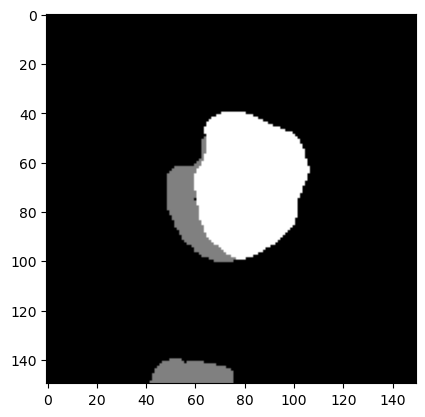

In [11]:
plt.imshow(sl_lab, cmap='gray')

In [12]:
np.save("example_00012_crop_lab.npy", sl_lab.detach().cpu().numpy().astype("float32"))
np.save("example_00012_crop.npy", sl_img.detach().cpu().numpy().astype("float32"))

In [24]:
np.save("example_00140_img_wh.npy", img.detach().cpu().numpy().astype("float32"))
np.save("example_00140_lab_wh.npy", seg.detach().cpu().numpy().astype("float32"))

In [13]:
image.save("example_00012_crop.jpg", format="JPEG", quality=95)

In [13]:
TRAINING_CASE_NUMBERS

[427, 57, 12, 479, 140]

### Model #1

For inference, the DINOv3 ViT-7B/16 model was used to address the train-inference domain gap. PCA on patch features showed little to no differentiation between organs at the embedding level. With non-linear dimensionality reduction, some organ differentiation appears, but no clear tumor–kidney separation. Patch embeddings colored by 6 k-means clusters also show no tumor or kidney differentiation; however, tumor patches form a small, tightly localized region in 2D UMAP.

Cosine-similarity maps indicate high similarity across organ patches with only slight differentiation between organ and tumor (in the example, a patch on healthy kidney highlights kidney more than the tumor region).

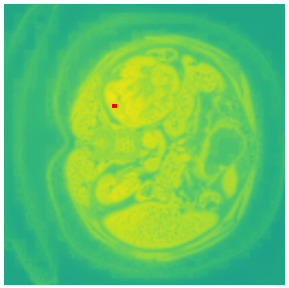

In [6]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vit7b16-pretrain-sat493m")
model = AutoModel.from_pretrained("facebook/dinov3-vit7b16-pretrain-sat493m", device_map="auto")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

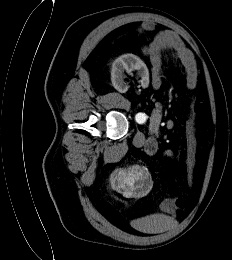

In [35]:
image = Image.open("example_00057.jpg").convert("RGB")

image

In [10]:
w, h = image.size
f = 16

patch_size = 16
h = int(np.ceil(h / patch_size) * patch_size * f)
w = int(np.ceil(w / patch_size) * patch_size * f)

h,w = 2048,2048

In [11]:
inputs = processor(
    images=image,
    return_tensors="pt",
    do_resize=True,
	size={"height": h, "width": w},
)

inputs = inputs.to(model.device)

with torch.inference_mode():
    outputs = model(**inputs)

# here are our image embeedings
# Output shape: [1, 1 + num_register_tokens + num_patches, hidden_size] :contentReference[oaicite:1]{index=1}
hiddens = outputs.last_hidden_state[0]  # [tokens, hidden_dim]

config = model.config
num_register = config.num_register_tokens
num_patches = hiddens.shape[0] - (1 + num_register)

# Discard [CLS] and register tokens, keep patch features
patch_feats = hiddens[1 + num_register:, :]  # shape: [num_patches, hidden_dim]

In [25]:
patch_size = getattr(model.config, "patch_size", 16)
H_px, W_px = inputs["pixel_values"].shape[-2:]
grid_h, grid_w = H_px // patch_size, W_px // patch_size

patch_feats_grid = patch_feats.reshape(grid_h, grid_w, -1)
print("patch_feats_grid:", patch_feats_grid.shape)

patch_feats_grid: torch.Size([128, 128, 4096])


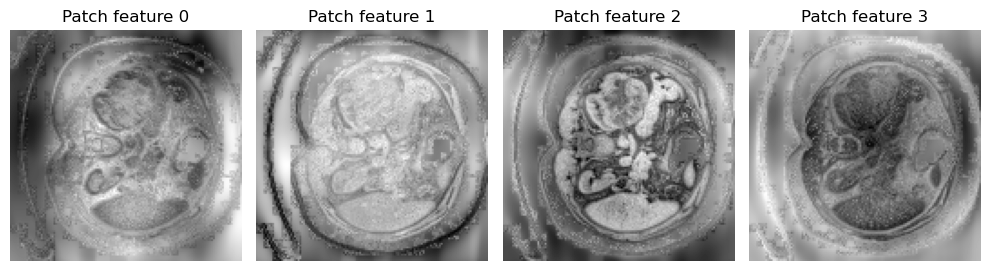

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
for i in range(4):
	ax[i].imshow(patch_feats_grid[:, :, i].detach().cpu().numpy(), cmap="gray")
	ax[i].set_title(f"Patch feature {i}")
	ax[i].axis("off")
plt.tight_layout()
plt.show()

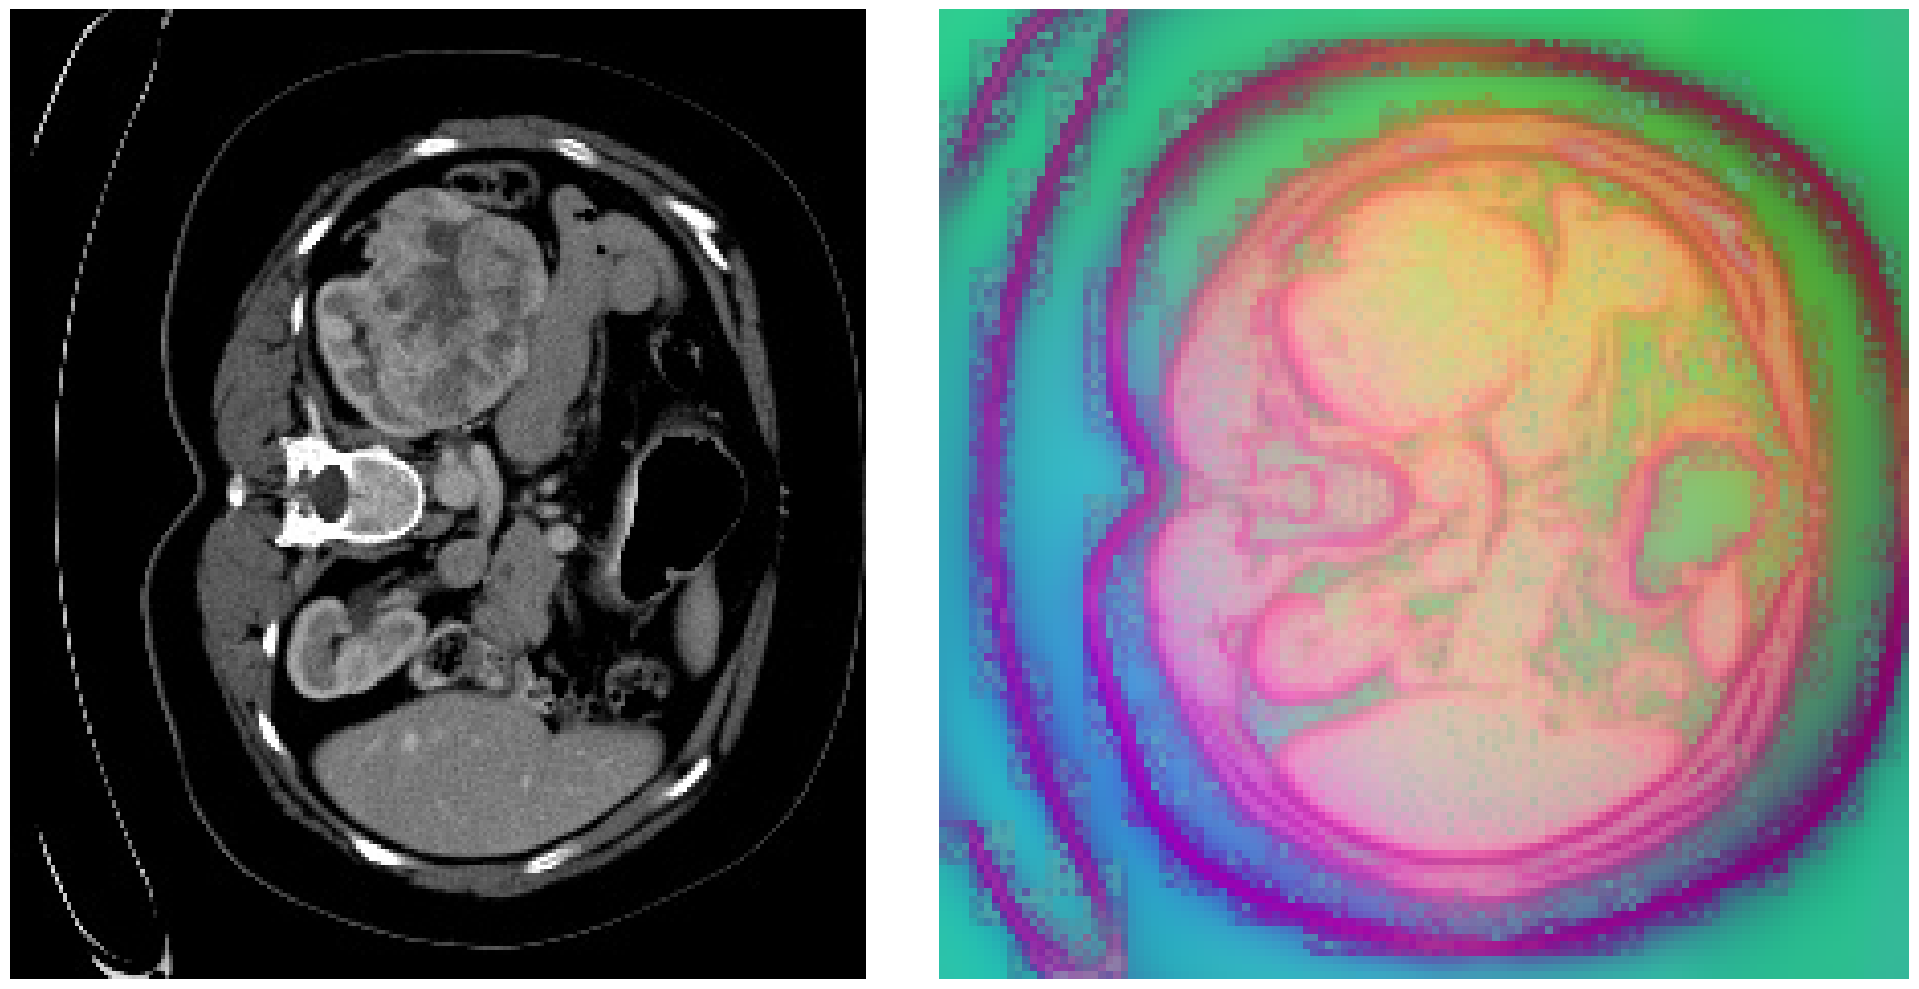

In [27]:
pca = PCA(n_components=3)
patch_feats_np = patch_feats.cpu().numpy()
patch_pca = pca.fit_transform(patch_feats_np)  # shape: [num_patches, 3]

# norm to [0, 1]
rgb = (patch_pca - patch_pca.min()) / (patch_pca.max() - patch_pca.min())

H_px, W_px = inputs["pixel_values"].shape[-2:]
grid_h, grid_w = H_px // patch_size, W_px // patch_size

rgb = rgb.reshape(grid_h, grid_w, 3)


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[1].imshow(rgb)
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


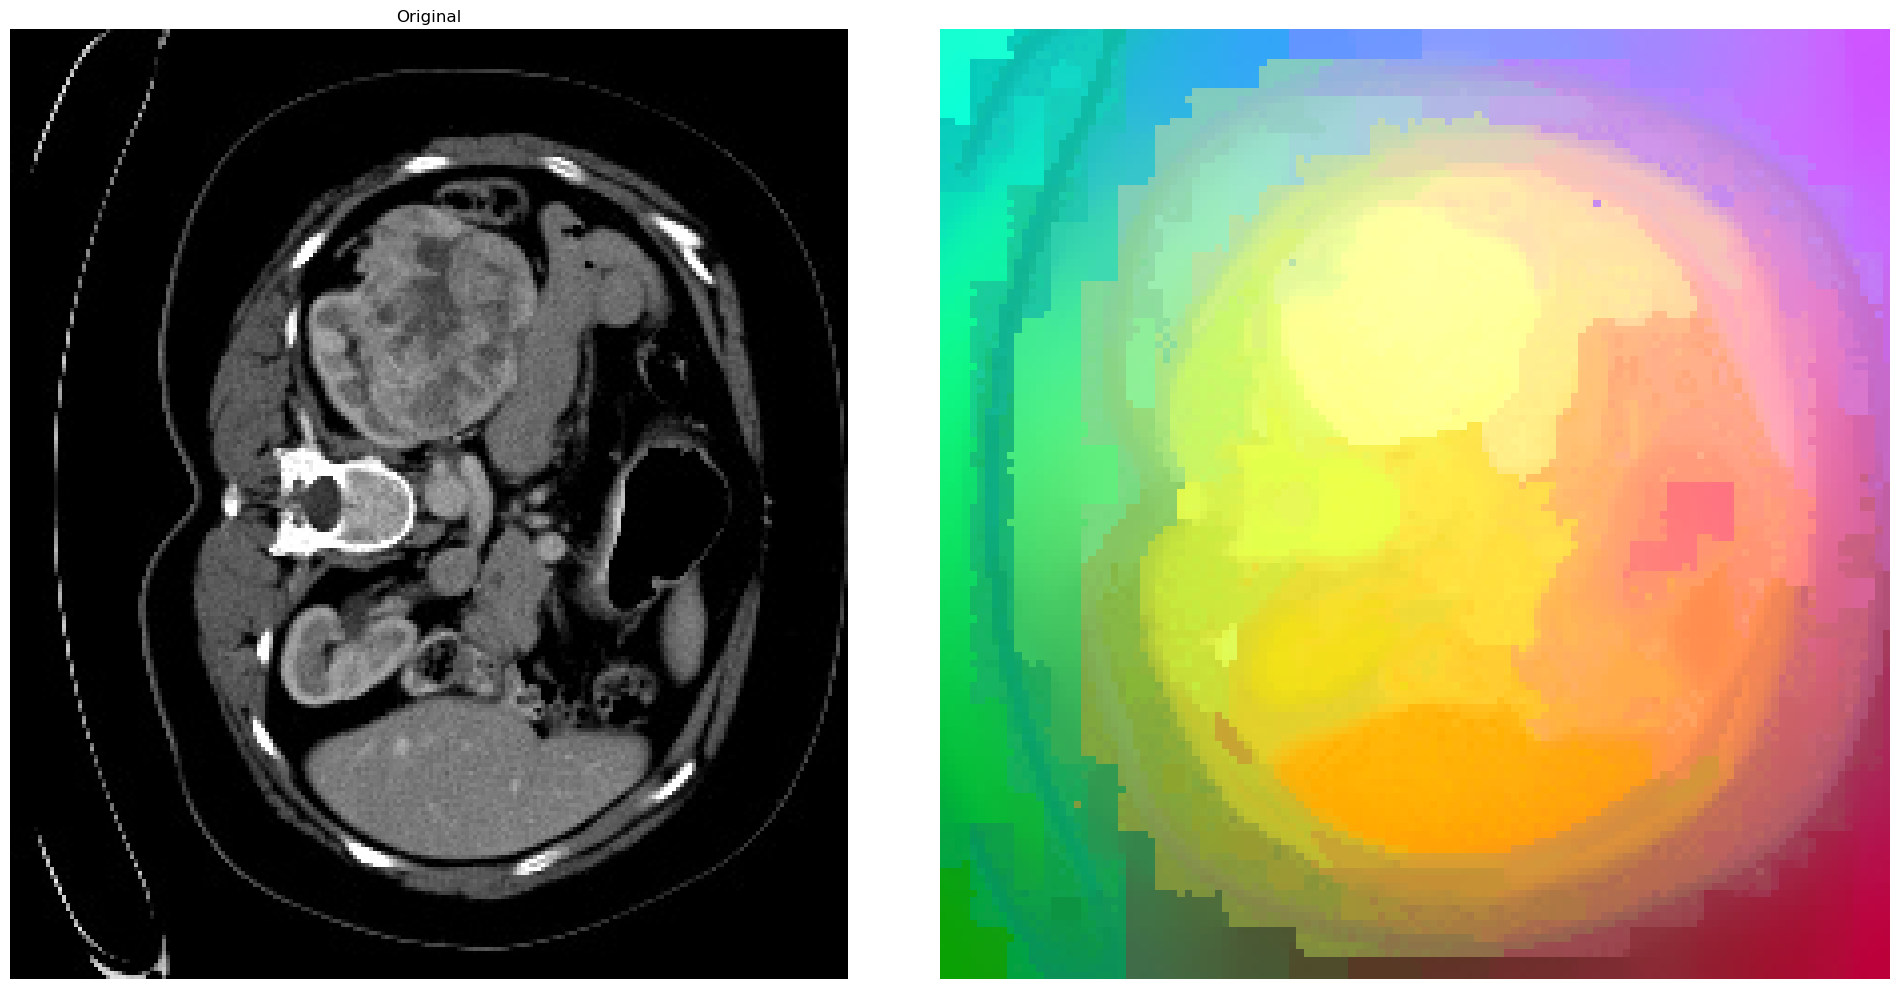

In [28]:
import umap

# 2) Run UMAP to 3D (so we can map directly to RGB)
X = patch_feats_np
umap_model = umap.UMAP(
    n_components=3,
    n_neighbors=15,          # tweak: smaller = local structure, larger = global
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_emb = umap_model.fit_transform(X)   # shape: [num_patches, 3]

# 3) Normalize to [0,1] for RGB image
rgb = (X_emb - X_emb.min(axis=0, keepdims=True)) / (X_emb.max(axis=0, keepdims=True) + 1e-8)
rgb = rgb.reshape(grid_h, grid_w, 3)

# 4) (optional) Upsample to match processed image size
# import torch.nn.functional as F
# rgb_t = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0).float()
# rgb_up = F.interpolate(rgb_t, size=(H_px, W_px), mode="bilinear", align_corners=False)[0].permute(1,2,0).numpy()
# show_img = rgb_up
show_img = rgb

# 5) Plot: original + UMAP colors
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image.convert("RGB"))
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(show_img)
ax[1].axis("off")

plt.tight_layout()
plt.show()

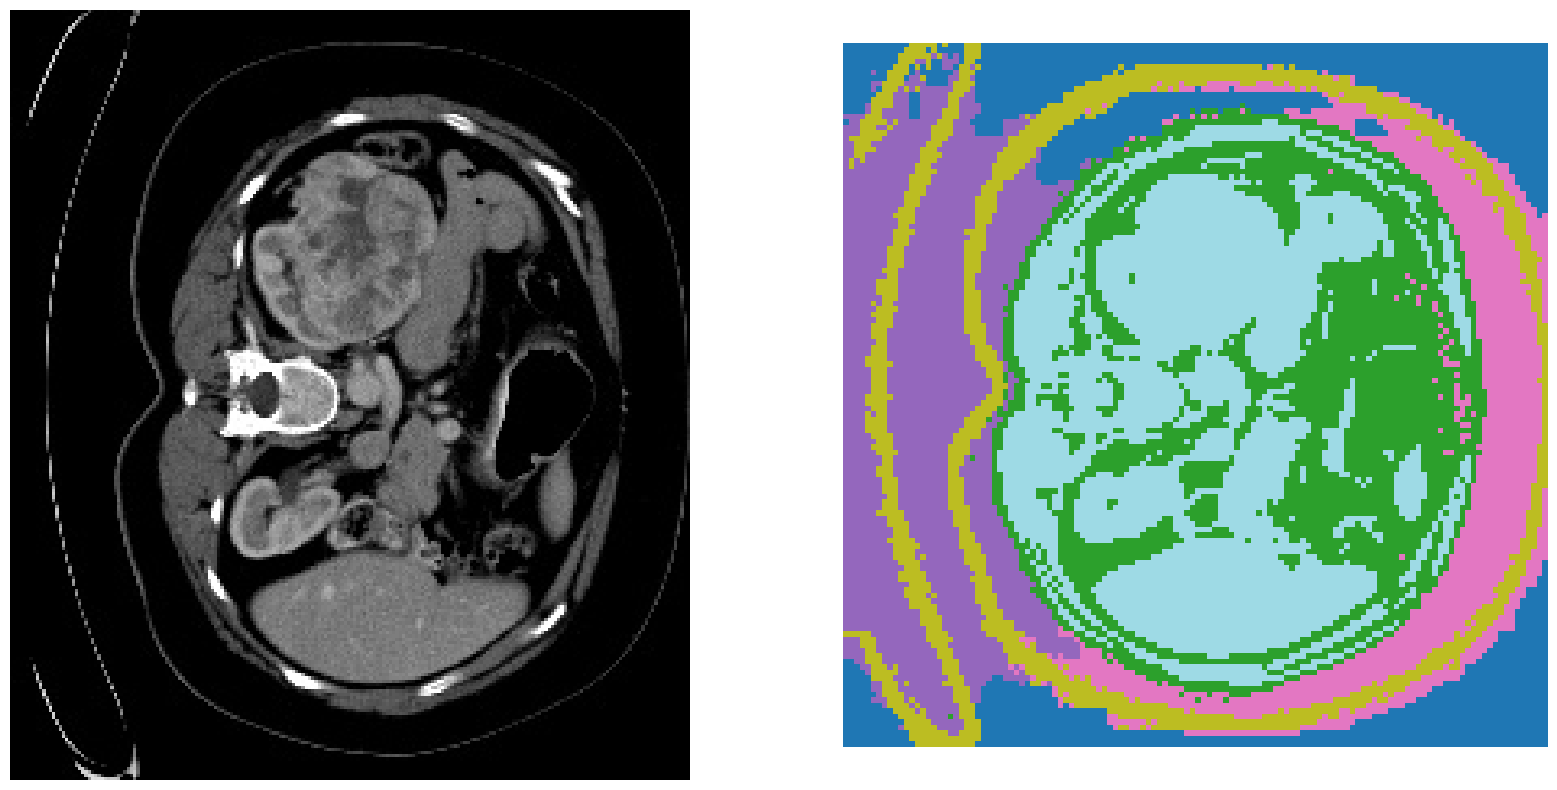

In [29]:
from sklearn.cluster import KMeans

K = 6
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)   # [num_patches]

H_px, W_px = inputs["pixel_values"].shape[-2:]
patch_size = getattr(model.config, "patch_size", 16)
grid_h, grid_w = H_px // patch_size, W_px // patch_size
seg_map = labels.reshape(grid_h, grid_w)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].axis("off")
ax[1].imshow(seg_map, cmap="tab20", interpolation="nearest")
ax[1].axis("off")
plt.show()

In [36]:
seg = np.load("example_00057_lab_wh.npy")
tumor = (seg == 2)
areas = tumor.sum(axis=(0, 1))  # [Z]
if areas.max() == 0:
    print("No tumor in this case")

z = int(areas.argmax())
sl_lab = seg[..., z]

# sl_lab = np.load("example_00012_crop_lab.npy")

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


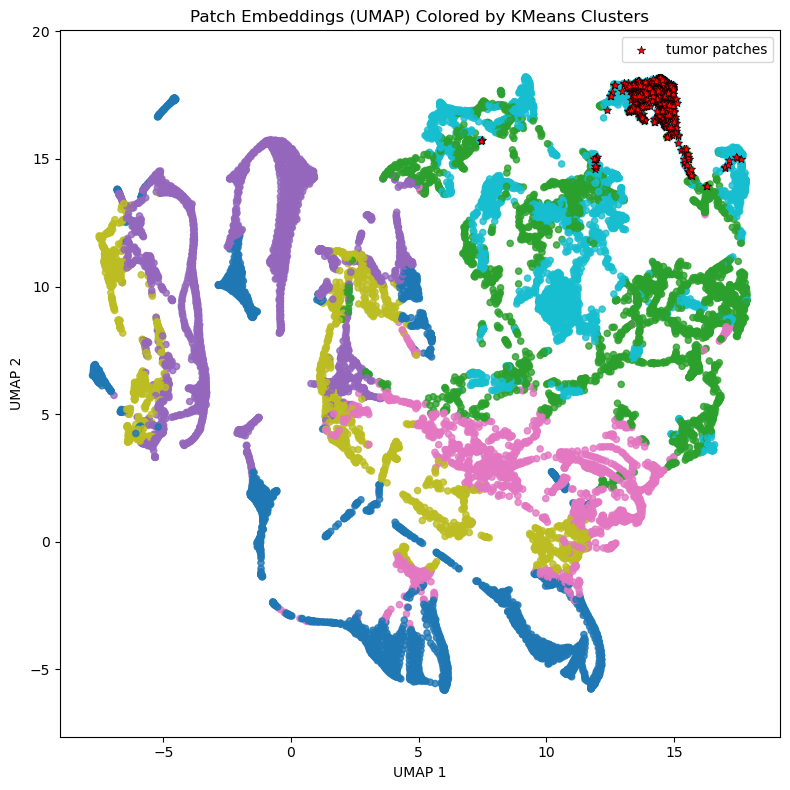

In [50]:
gH, gW = 128, 128

# make tumor mask on patch grid
m = (sl_lab == 2).astype(np.float32)
m_t = torch.from_numpy(m)[None, None]
m_grid = F.interpolate(m_t, size=(gH, gW), mode="nearest")[0,0]
tum_idx = m_grid.flatten().bool().cpu().numpy()

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_2d = umap_model.fit_transform(X)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    s=20,
    c=labels,
    cmap="tab10",
    alpha=0.8
)

# overlay tumor patches
plt.scatter(X_2d[tum_idx,0], X_2d[tum_idx,1],
            s=40, marker='*', c='red', edgecolors='k', linewidths=0.4,
            label='tumor patches', zorder=3)

plt.title("Patch Embeddings (UMAP) Colored by KMeans Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
def extract_patch_tokens(model, processor, image, size=224):
    """
    Returns:
      patch_tokens: [1, N, D]
      grid_h, grid_w: patch grid size
      H_px, W_px: processed image size
      patch: patch size
    """
    patch = getattr(model.config, "patch_size", 16)

    inputs = processor(
        images=image,
        return_tensors="pt",
        do_resize=True,
        size={"height": size, "width": size},   # enforce square
        do_center_crop=False
    )
    inputs = inputs.to(model.device)

    with torch.inference_mode():
        outputs = model(**inputs)

    # tokens = [CLS] + [register]*R + [patch]*N
    hiddens = outputs.last_hidden_state  # [1, T, D]
    num_register = getattr(model.config, "num_register_tokens", 0)
    patch_tokens = hiddens[:, 1 + num_register :, :]  # [1, N, D]

    B, N, D = patch_tokens.shape
    grid_h, grid_w = size // patch, size // patch
    assert grid_h * grid_w == N, f"Token count {N} != grid {grid_h}x{grid_w}"
    return patch_tokens, grid_h, grid_w, size, size, patch


def cosine_map_for_ref(feats_norm, grid_h, grid_w, ref_yx):
    """feats_norm: [N,D] L2-normalized. Return (grid_h,grid_w) cosine map for reference patch (y,x)."""
    N, D = feats_norm.shape
    y, x = ref_yx
    y = max(0, min(grid_h-1, y))
    x = max(0, min(grid_w-1, x))
    idx = y * grid_w + x
    sims = feats_norm @ feats_norm[idx]
    return sims.view(grid_h, grid_w).cpu().numpy()

def upsample_map(sim_map, H_px, W_px):
    t = torch.from_numpy(sim_map)[None, None].float()
    up = F.interpolate(t, size=(H_px, W_px), mode="bilinear", align_corners=False)
    return up[0, 0].numpy()

def draw_red_patch(ax, ref_yx, H_px, W_px, grid_h, grid_w):
    """Overlay a red rectangle marking the reference patch (in pixel coords)."""
    y, x = ref_yx
    cell_h = H_px / grid_h
    cell_w = W_px / grid_w
    rect = Rectangle((x*cell_w, y*cell_h), cell_w, cell_h,
                     linewidth=1.5, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

In [10]:
def plot_patch_similarity_maps(model, processor, image, size=1024, num_refs=5, refs_per_row=4, seed=None, y1=None, y2=None, x1=None, x2=None):
    """
    Plot cosine similarity maps for randomly chosen reference patches.

    Args:
        model: HuggingFace model
        processor: HuggingFace processor
        image: PIL.Image
        size (int): resized image size (must be divisible by patch size)
        num_refs (int): number of reference patches
        refs_per_row (int): how many plots per row
        seed (int, optional): random seed for reproducibility
    """
    if seed is not None:
        np.random.seed(seed)

    # --- extract patch tokens ---
    patch_tokens, gh, gw, H_px, W_px, patch = extract_patch_tokens(model, processor, image, size=size)
    feats = F.normalize(patch_tokens[0], p=2, dim=-1)  # [N,D]

    if x1 is None: x1=0
    if y1 is None: y1=0
    if x2 is None: x2=gw
    if y2 is None: y2=gh
    
    # pick random refs
    ref_patches = list(zip(np.random.randint(y1, y2, size=num_refs),
                           np.random.randint(x1, x2, size=num_refs)))

    # grid setup: one original + all sim maps
    total_plots = 2 + num_refs
    rows = (total_plots + refs_per_row - 1) // refs_per_row
    cols = refs_per_row

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()
    im_last = None

    # --- plot original in first axis ---
    axes[0].imshow(image.convert("RGB").resize((W_px, H_px)))
    axes[0].axis("off")
    
    segmentation = F.interpolate(torch.tensor(sl_lab)[None, None], size=(2048,2048), mode="bilinear", align_corners=False)[0,0]
    axes[1].imshow(segmentation, cmap='gray')
    axes[1].axis("off")

    cell_h, cell_w = H_px / gh, W_px / gw
    for ref in ref_patches:
        y, x = ref
        rect = Rectangle((x*cell_w, y*cell_h), cell_w, cell_h,
                         linewidth=1.5, edgecolor='red', facecolor='none')
        rect1 = Rectangle((x*cell_w, y*cell_h), cell_w, cell_h,
                         linewidth=1.5, edgecolor='red', facecolor='none')
        axes[0].add_patch(rect)
        axes[1].add_patch(rect1)

    # --- plot cosine sim maps ---
    for i, ref in enumerate(ref_patches, start=2):
        sim_map = cosine_map_for_ref(feats, gh, gw, ref)
        sim_up = upsample_map(sim_map, H_px, W_px)

        ax = axes[i]
        im_last = ax.imshow(sim_up, cmap="viridis", vmin=-1.0, vmax=1.0)
        ax.axis("off")

        y, x = ref
        rect = Rectangle((x*cell_w, y*cell_h), cell_w, cell_h,
                         linewidth=1.5, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # turn off any unused axes
    for j in range(2 + num_refs, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

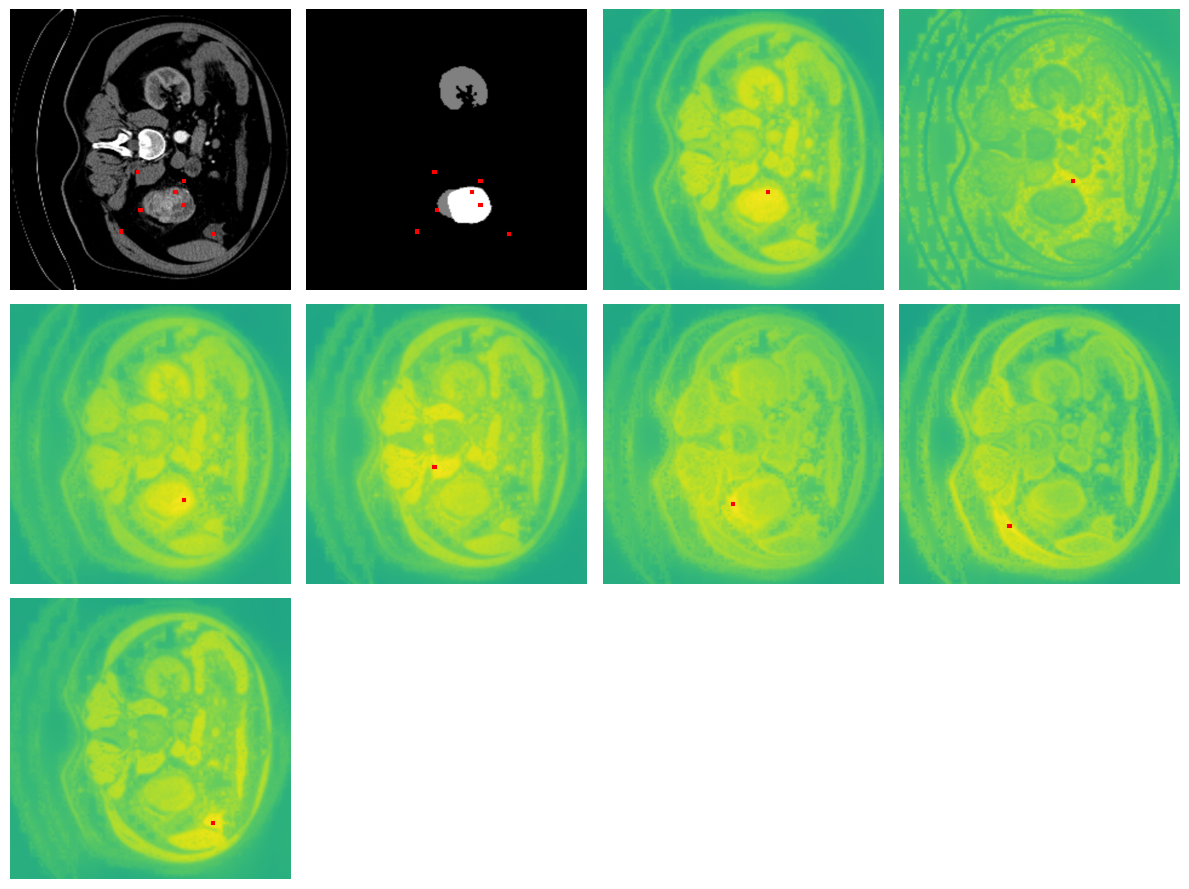

In [49]:
plot_patch_similarity_maps(model, processor, image, size=2048, num_refs=7, refs_per_row=4, seed=10, y1=74, y2=103, x1=50, x2=93)

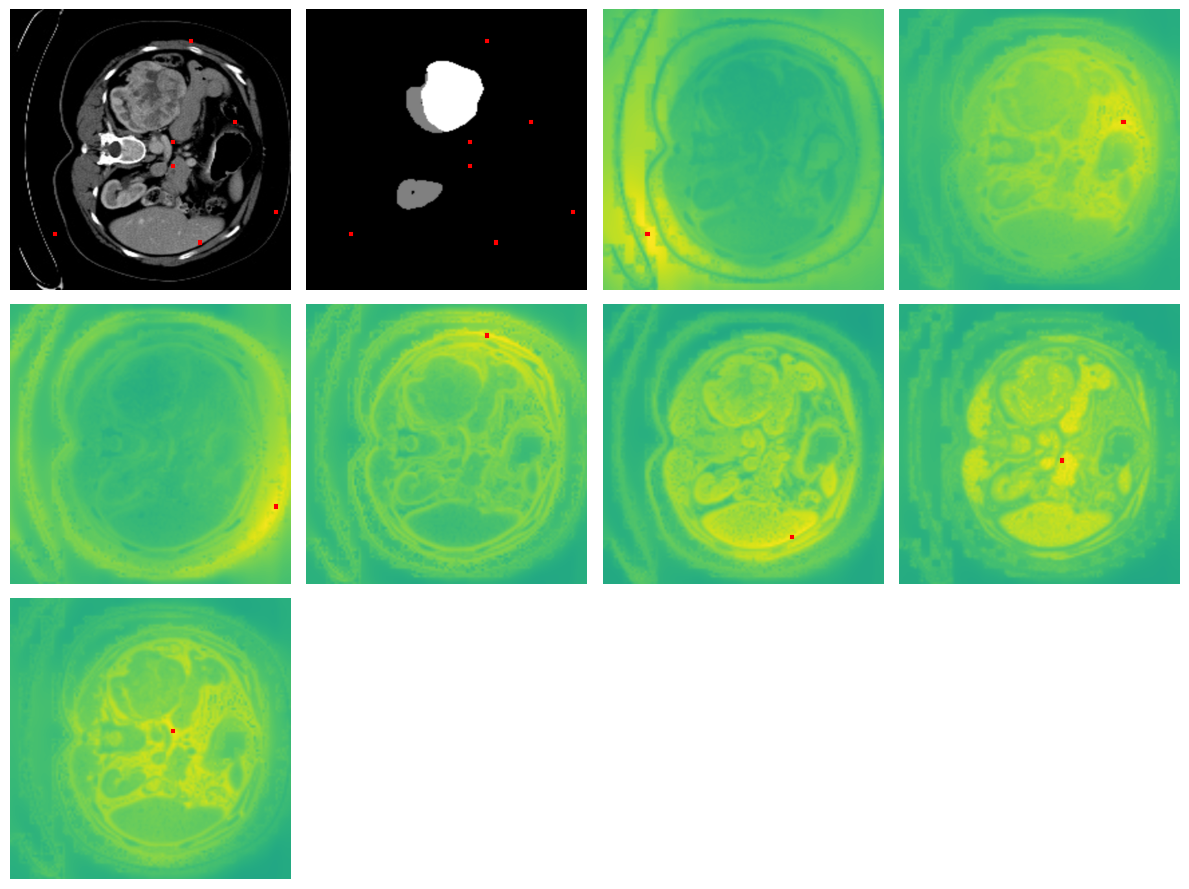

In [43]:
plot_patch_similarity_maps(model, processor, image, size=2048, num_refs=7, refs_per_row=4, seed=42)

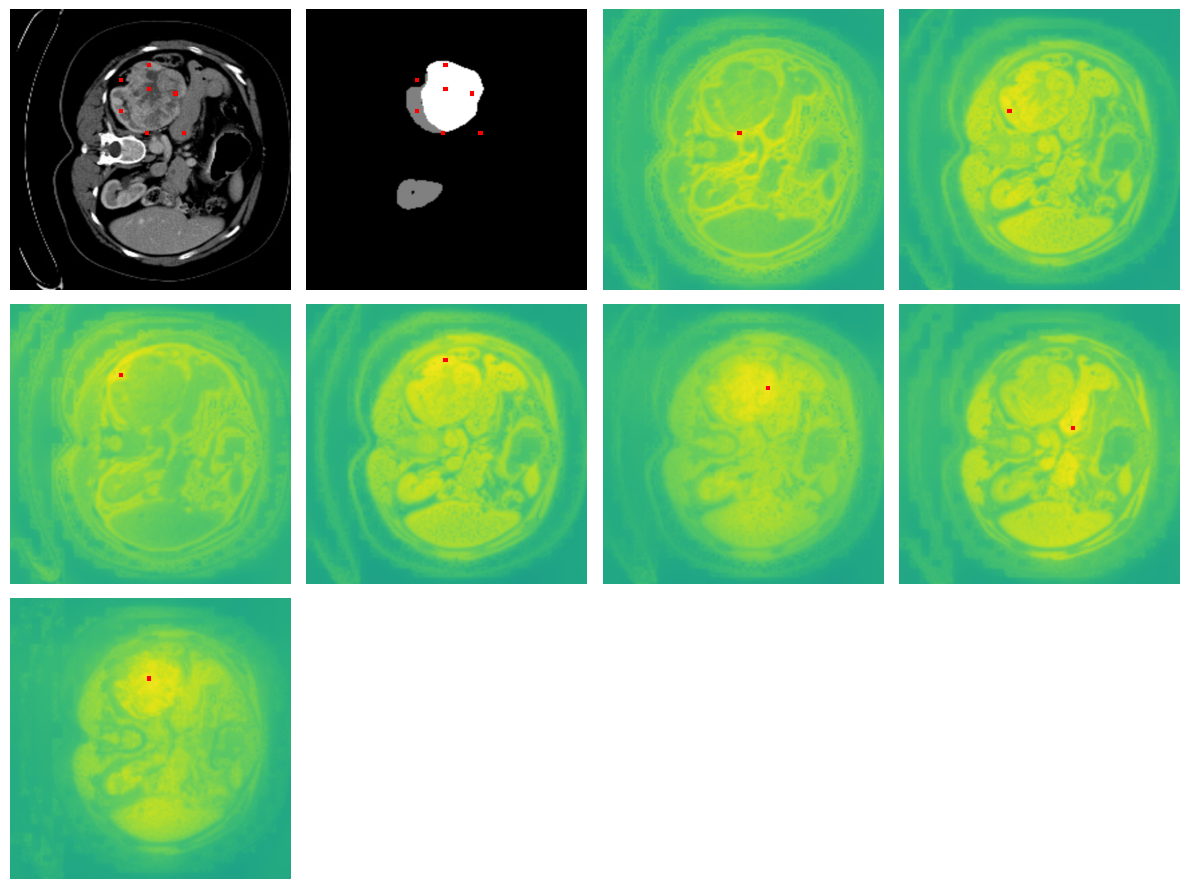

In [44]:
plot_patch_similarity_maps(model, processor, image, size=2048, num_refs=7, refs_per_row=4, seed=42, y1=18, y2=59, x1=40, x2=84)

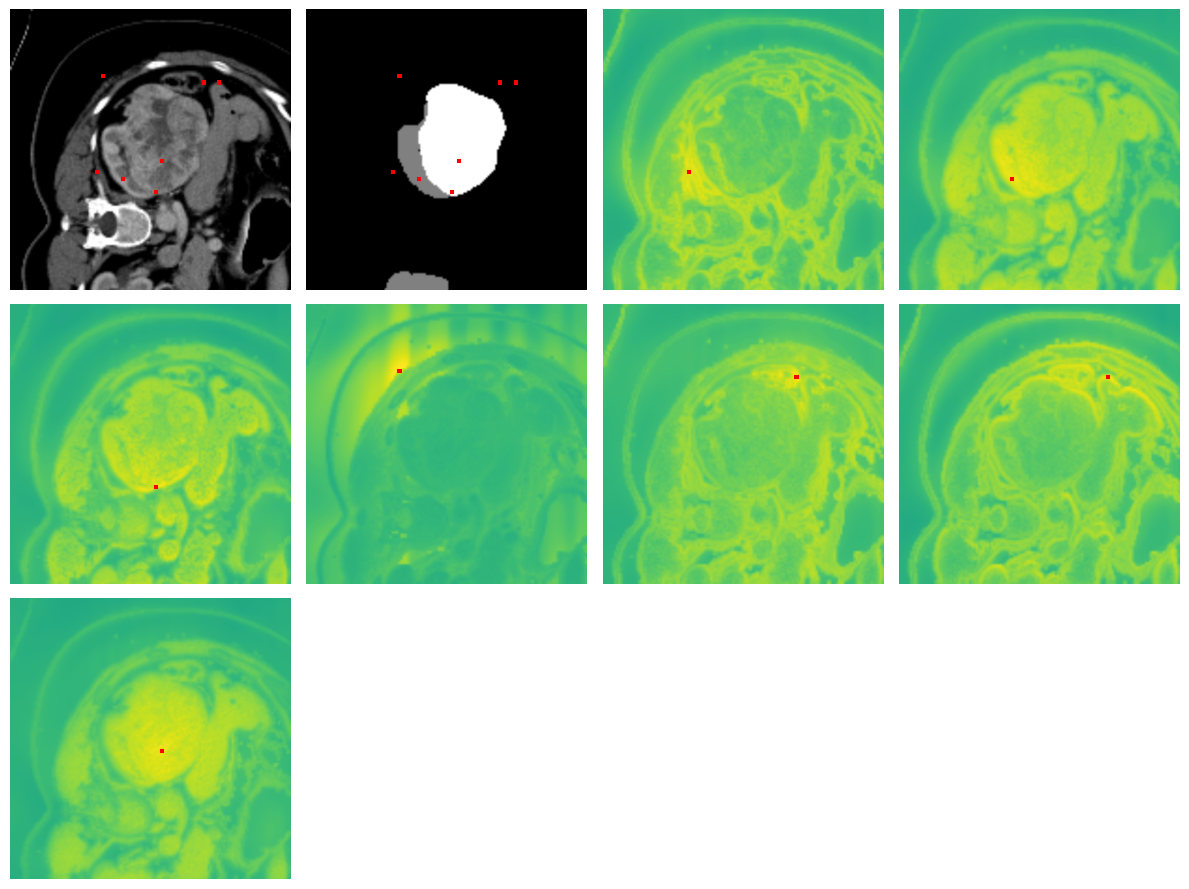

In [34]:
plot_patch_similarity_maps(model, processor, image, size=2048, num_refs=7, refs_per_row=4, seed=0, y1=30, y2=89, x1=30, x2=97)

### Model #2

The same experiments were conducted using a domain-adapted, pretrained MedDINOv3 model. Here, dimensionality reduction on patch features shows more inter-organ differentiation (non-linear works better). Cosine-similarity maps show more localized similarity patterns that mostly stay within organ boundaries. The highlighted area remains large, with limited anatomical precision, which could be improved with fine-tuning and alternative data-preparation pipelines. Tumor-organ differentiation is present and can likely be improved with additional training.

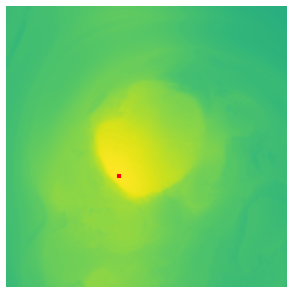

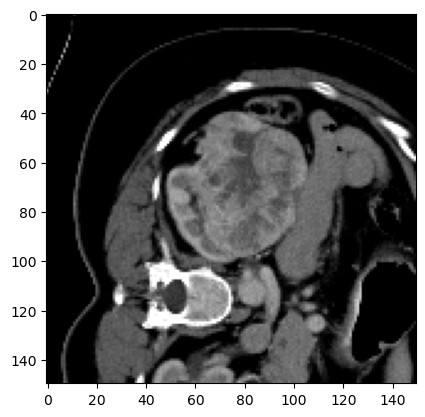

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sl_img = torch.tensor(np.load("example_00012_crop.npy"), device=device)

H, W = 2048, 2048
sl_img_r = F.interpolate(sl_img[None, None], size=(H, W), mode="bilinear", align_corners=False)[0,0]
sl_img_r = sl_img_r.repeat(3, 1, 1)

# seg = np.load("example_00012_lab_wh.npy")
# tumor = (seg == 2)
# areas = tumor.sum(axis=(0, 1))  # [Z]
# if areas.max() == 0:
#     print("No tumor in this case")

# z = int(areas.argmax())
# sl_lab = seg[..., z]

sl_lab = np.load("example_00012_crop_lab.npy")

plt.imshow(sl_img.cpu().detach().numpy(), cmap='gray')

In [9]:
model = vit_base(drop_path_rate=0.2, layerscale_init=1.0e-05, n_storage_tokens=4, 
                    qkv_bias = False, mask_k_bias= True)

device = torch.device("cuda:0")
chkpt_path = 'model.pth'
chkpt = torch.load(chkpt_path, 
                     weights_only=False, map_location='cpu')
state_dict = chkpt['teacher']
state_dict = {
    k.replace('backbone.', ''): v
    for k, v in state_dict.items()
    if 'ibot' not in k and 'dino_head' not in k
}
model.load_state_dict(state_dict)
model.to(device)
model.eval()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): Layer

In [10]:
sample = sl_img_r.clone()

with torch.no_grad():
    features = model(sample.unsqueeze(0).to(device), is_training=True)['x_norm_patchtokens']

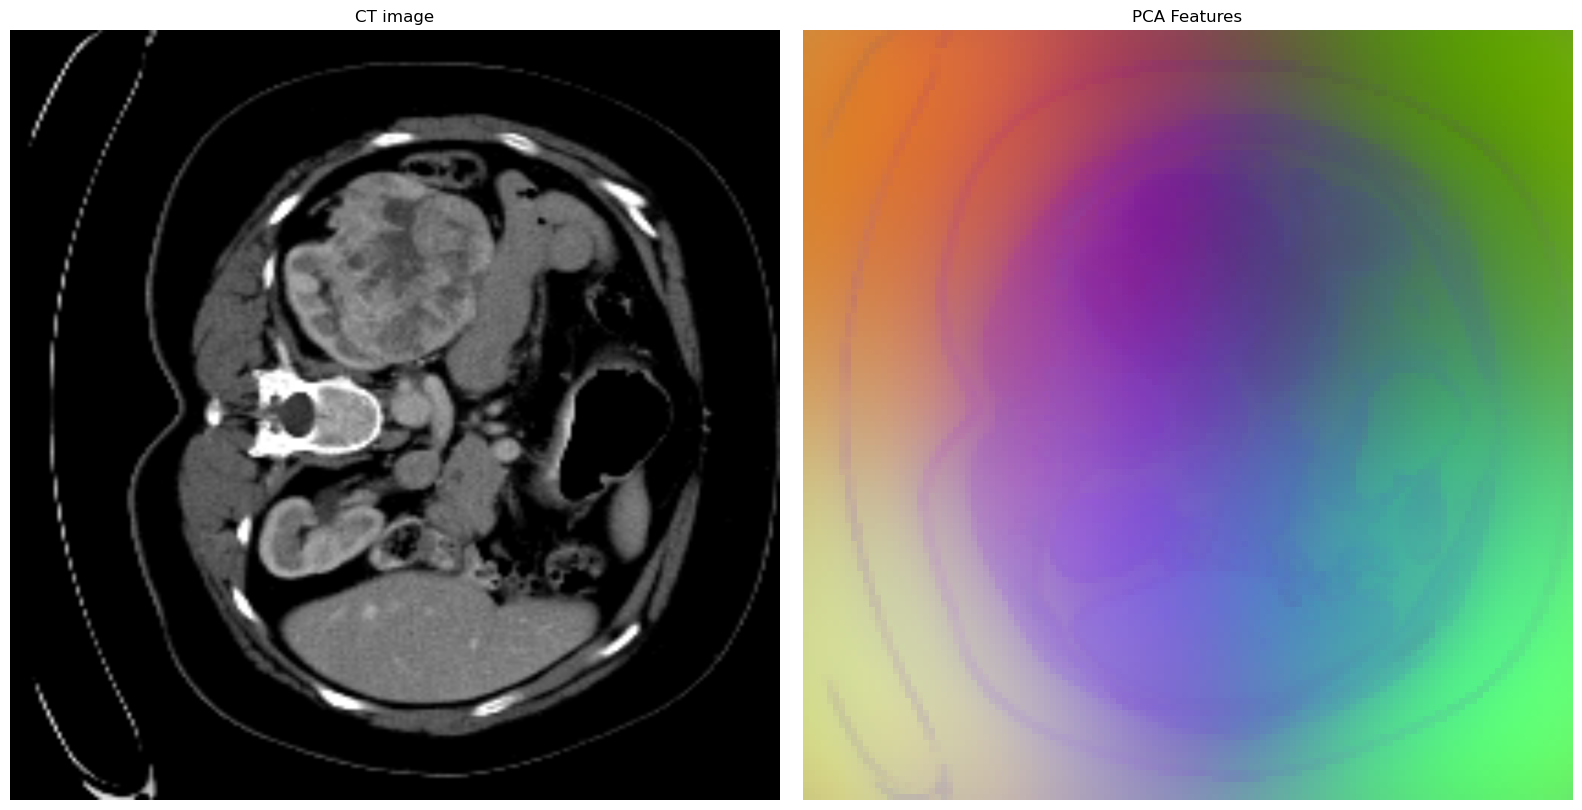

In [11]:
input_size = sample.size()[1]

pca = PCA(n_components=3, whiten=True)
pca_features = pca.fit_transform(features.squeeze(0).cpu().detach().numpy()) # [input_size*input_size, 3]

# put pca features into 0-1 scale
norm_pca_feats = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
norm_pca_feats = norm_pca_feats.reshape(input_size//model.patch_size, input_size//model.patch_size, -1)

# Create one figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # (rows=1, cols=2), adjust figsize for bigger plot

# First subplot: CT image
axes[0].imshow(np.transpose(sample.cpu().detach().numpy(), (1,2,0)), cmap="gray")
axes[0].axis('off')
axes[0].set_title("CT image")

# Second subplot: PCA features
axes[1].imshow(norm_pca_feats)
axes[1].axis('off')
axes[1].set_title("PCA Features")

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


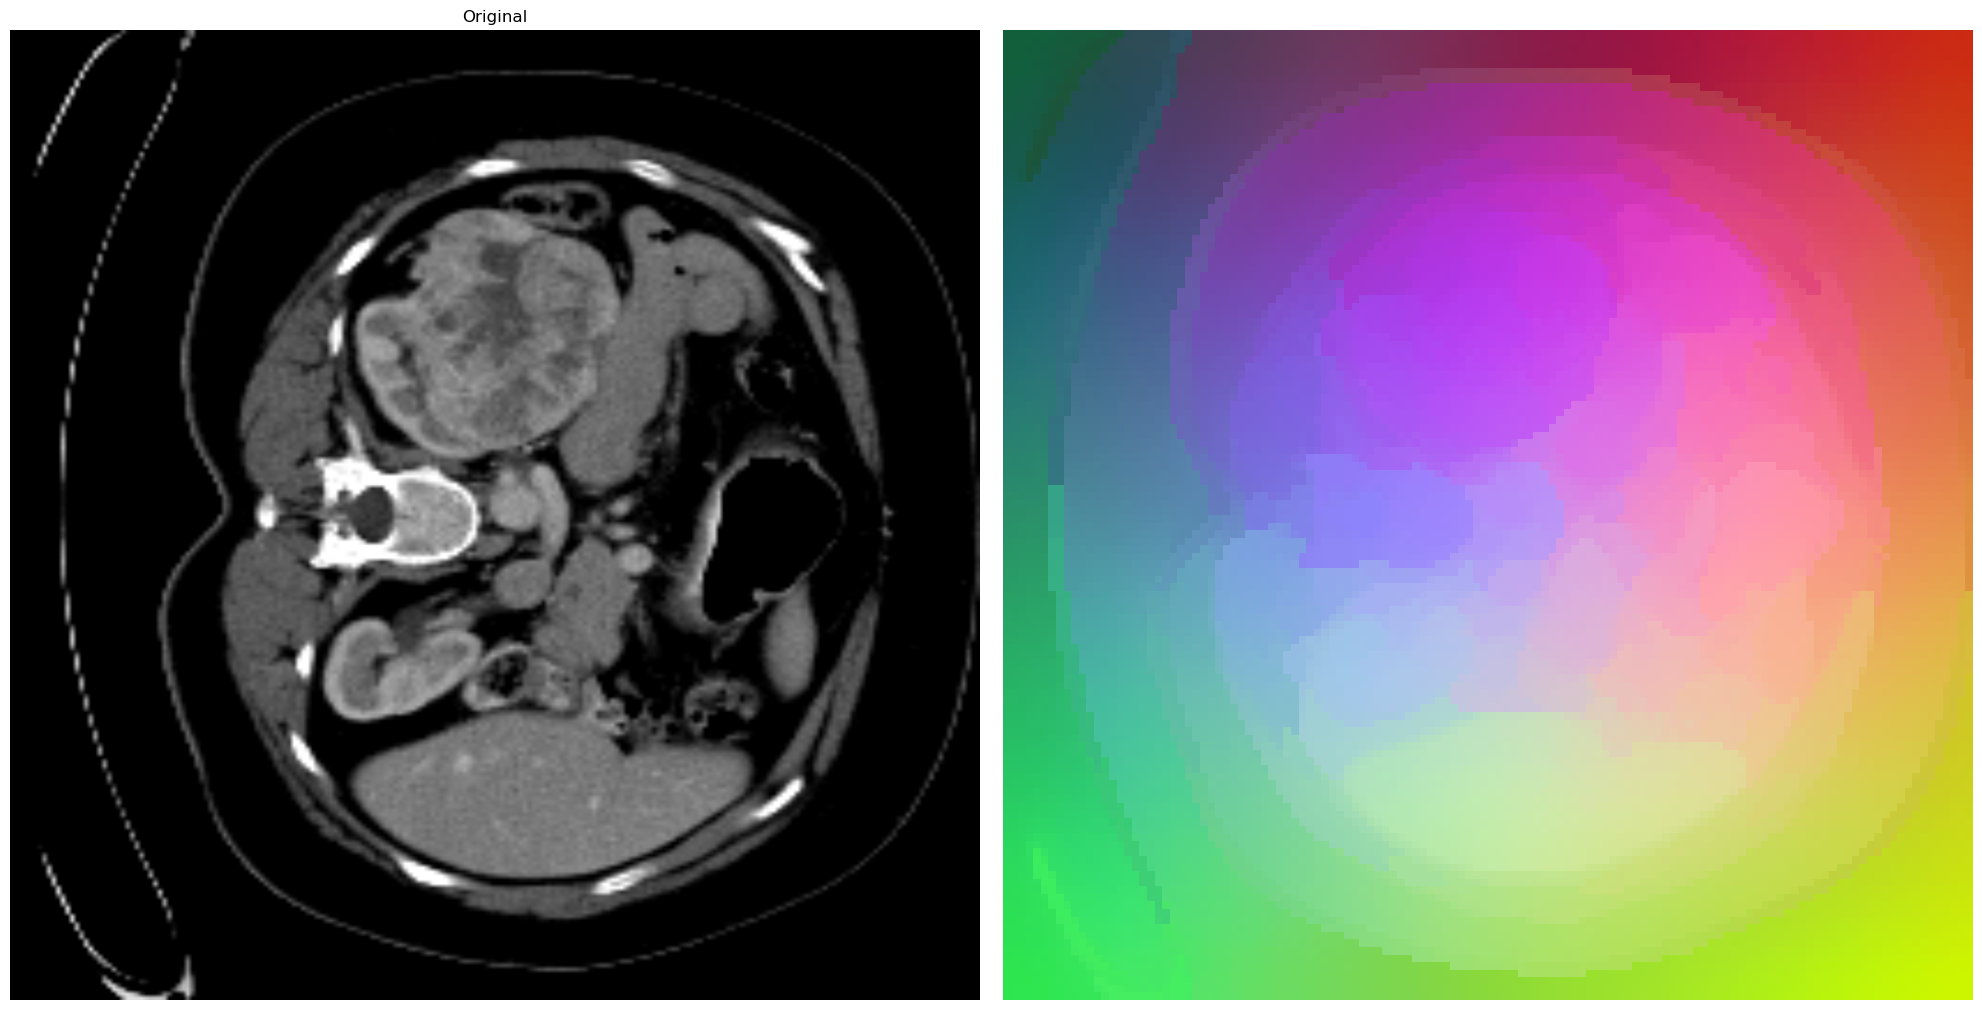

In [12]:
# 2) Run UMAP to 3D (so we can map directly to RGB)
X = features.squeeze(0).cpu().detach().numpy()

umap_model = umap.UMAP(
    n_components=3,
    n_neighbors=15,          # tweak: smaller = local structure, larger = global
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_emb = umap_model.fit_transform(X)   # shape: [num_patches, 3]

# 3) Normalize to [0,1] for RGB image
rgb = (X_emb - X_emb.min()) / (X_emb.max() - X_emb.min())
rgb = rgb.reshape(input_size//model.patch_size, input_size//model.patch_size, -1)

# 4) (optional) Upsample to match processed image size
# import torch.nn.functional as F
# rgb_t = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0).float()
# rgb_up = F.interpolate(rgb_t, size=(H_px, W_px), mode="bilinear", align_corners=False)[0].permute(1,2,0).numpy()
# show_img = rgb_up
show_img = rgb

# 5) Plot: original + UMAP colors
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(np.transpose(sample.cpu().detach().numpy(), (1,2,0)), cmap="gray")
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(show_img)
ax[1].axis("off")

plt.tight_layout()
plt.show()

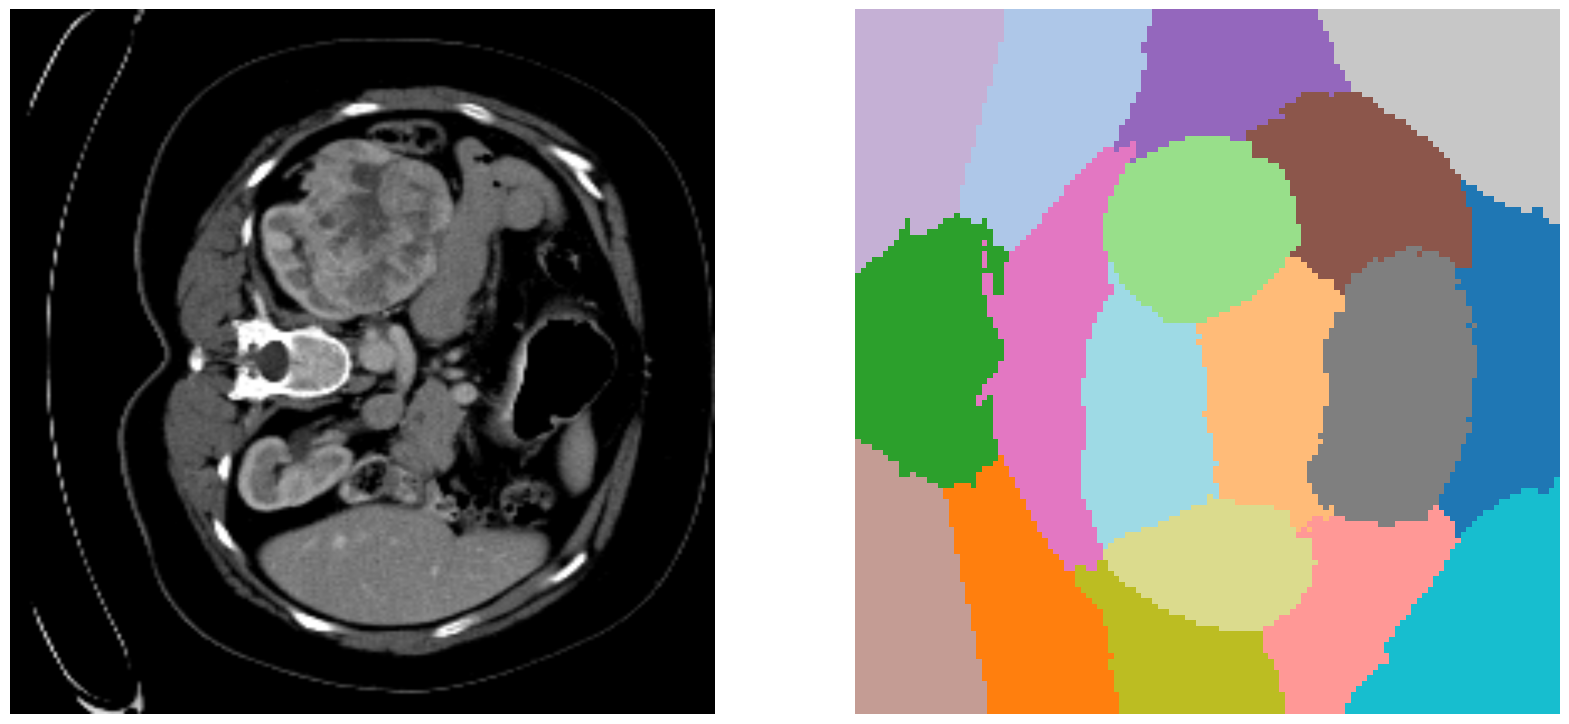

In [17]:
K = 18
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)   # [num_patches]

seg_map = labels.reshape(input_size//model.patch_size, input_size//model.patch_size, -1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(np.transpose(sample.cpu().detach().numpy(), (1,2,0)), cmap="gray")
ax[0].axis("off")
ax[1].imshow(seg_map, cmap="tab20", interpolation="nearest")
ax[1].axis("off")
plt.show()

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


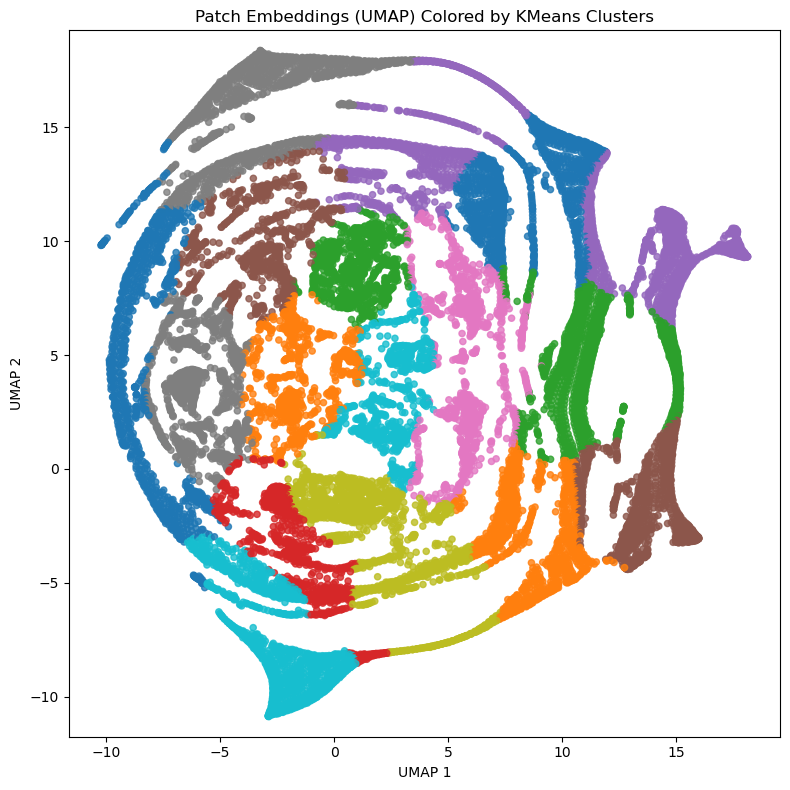

In [18]:
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
X_2d = umap_model.fit_transform(X)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    s=20,
    c=labels,
    cmap="tab10",
    alpha=0.8
)

plt.title("Patch Embeddings (UMAP) Colored by KMeans Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [10]:
def extract_patch_tokens(model, sample, size=2048):
    """
    Returns:
      patch_tokens: [1, N, D]
      grid_h, grid_w: patch grid size
      H_px, W_px: processed image size
      patch: patch size
    """
    patch = model.patch_size

    with torch.no_grad():
        outputs = model(sample.unsqueeze(0).to(device), is_training=True)

    patch_tokens = outputs['x_norm_patchtokens']  # [1, N, D]

    B, N, D = patch_tokens.shape
    grid_h, grid_w = size // patch, size // patch
    assert grid_h * grid_w == N, f"Token count {N} != grid {grid_h}x{grid_w}"
    return patch_tokens, grid_h, grid_w, size, size, patch


def cosine_map_for_ref(feats_norm, grid_h, grid_w, ref_yx):
    """feats_norm: [N,D] L2-normalized. Return (grid_h,grid_w) cosine map for reference patch (y,x)."""
    N, D = feats_norm.shape
    y, x = ref_yx
    y = max(0, min(grid_h-1, y))
    x = max(0, min(grid_w-1, x))
    idx = y * grid_w + x
    sims = feats_norm @ feats_norm[idx]
    return sims.view(grid_h, grid_w).cpu().numpy()

def upsample_map(sim_map, H_px, W_px):
    t = torch.from_numpy(sim_map)[None, None].float()
    up = F.interpolate(t, size=(H_px, W_px), mode="bilinear", align_corners=False)
    return up[0, 0].numpy()

def draw_red_patch(ax, ref_yx, H_px, W_px, grid_h, grid_w):
    """Overlay a red rectangle marking the reference patch (in pixel coords)."""
    y, x = ref_yx
    cell_h = H_px / grid_h
    cell_w = W_px / grid_w
    rect = Rectangle((x*cell_w, y*cell_h), cell_w, cell_h,
                     linewidth=1.5, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

In [19]:
def plot_patch_similarity_maps(model, image, size=1024, num_refs=5, refs_per_row=4, seed=None, y1=None, y2=None, x1=None, x2=None):
    """
    Plot cosine similarity maps for randomly chosen reference patches.

    Args:
        model: HuggingFace model
        processor: HuggingFace processor
        image: PIL.Image
        size (int): resized image size (must be divisible by patch size)
        num_refs (int): number of reference patches
        refs_per_row (int): how many plots per row
        seed (int, optional): random seed for reproducibility
    """
    if seed is not None:
        np.random.seed(seed)

    # --- extract patch tokens ---
    patch_tokens, gh, gw, H_px, W_px, patch = extract_patch_tokens(model, image, size=size)
    feats = F.normalize(patch_tokens[0], p=2, dim=-1)  # [N,D]

    if x1 is None: x1=0
    if y1 is None: y1=0
    if x2 is None: x2=gw
    if y2 is None: y2=gh
    
    # pick random refs
    ref_patches = list(zip(np.random.randint(y1, y2, size=num_refs),
                           np.random.randint(x1, x2, size=num_refs)))

    # grid setup: one original + all sim maps
    total_plots = 2 + num_refs
    rows = (total_plots + refs_per_row - 1) // refs_per_row
    cols = refs_per_row

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()
    im_last = None

    # --- plot original in first axis ---
    sl8 = (sample[0, ...] * 255).to(torch.uint8).cpu().numpy()
    image = Image.fromarray(sl8, mode="L")
    axes[0].imshow(image.convert("RGB").resize((W_px, H_px)))
    axes[0].axis("off")
    
    segmentation = F.interpolate(torch.tensor(sl_lab)[None, None], size=(2048,2048), mode="bilinear", align_corners=False)[0,0]
    axes[1].imshow(segmentation, cmap='gray')
    axes[1].axis("off")

    cell_h, cell_w = H_px / gh, W_px / gw
    for ref in ref_patches:
        y, x = ref
        rect = Rectangle((x*cell_w, y*cell_h), cell_w, cell_h,
                         linewidth=1.5, edgecolor='red', facecolor='none')
        rect1 = Rectangle((x*cell_w, y*cell_h), cell_w, cell_h,
                         linewidth=1.5, edgecolor='red', facecolor='none')
        axes[0].add_patch(rect)
        axes[1].add_patch(rect1)

    # --- plot cosine sim maps ---
    for i, ref in enumerate(ref_patches, start=2):
        sim_map = cosine_map_for_ref(feats, gh, gw, ref)
        sim_up = upsample_map(sim_map, H_px, W_px)

        ax = axes[i]
        im_last = ax.imshow(sim_up, cmap="viridis", vmin=-1.0, vmax=1.0)
        ax.axis("off")

        y, x = ref
        rect = Rectangle((x*cell_w, y*cell_h), cell_w, cell_h,
                         linewidth=1.5, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # turn off any unused axes
    for j in range(2 + num_refs, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

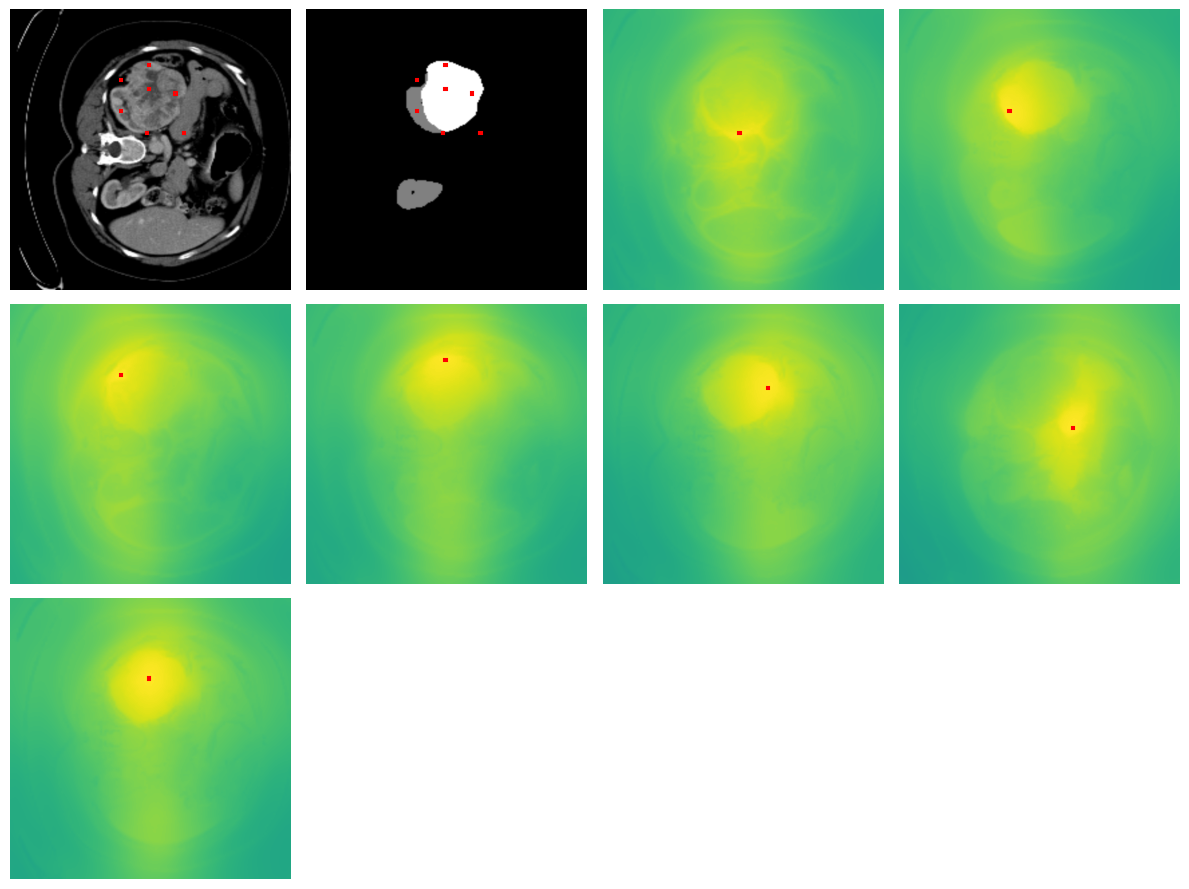

In [23]:
sample = sl_img_r.clone()

plot_patch_similarity_maps(model, sample, size=2048, num_refs=7, refs_per_row=4, seed=42, y1=18, y2=59, x1=40, x2=84)

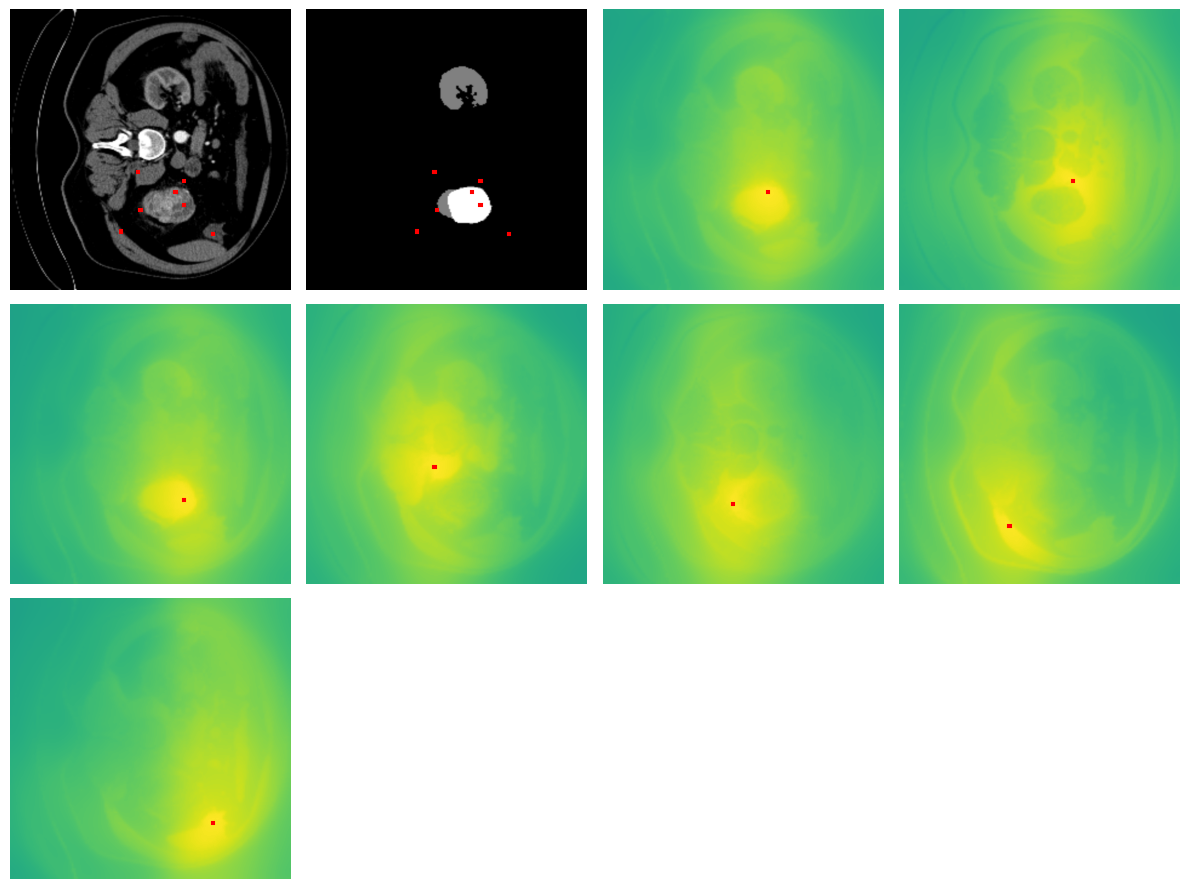

In [21]:
sample = sl_img_r.clone()

plot_patch_similarity_maps(model, sample, size=2048, num_refs=7, refs_per_row=4, seed=10, y1=74, y2=103, x1=50, x2=93)

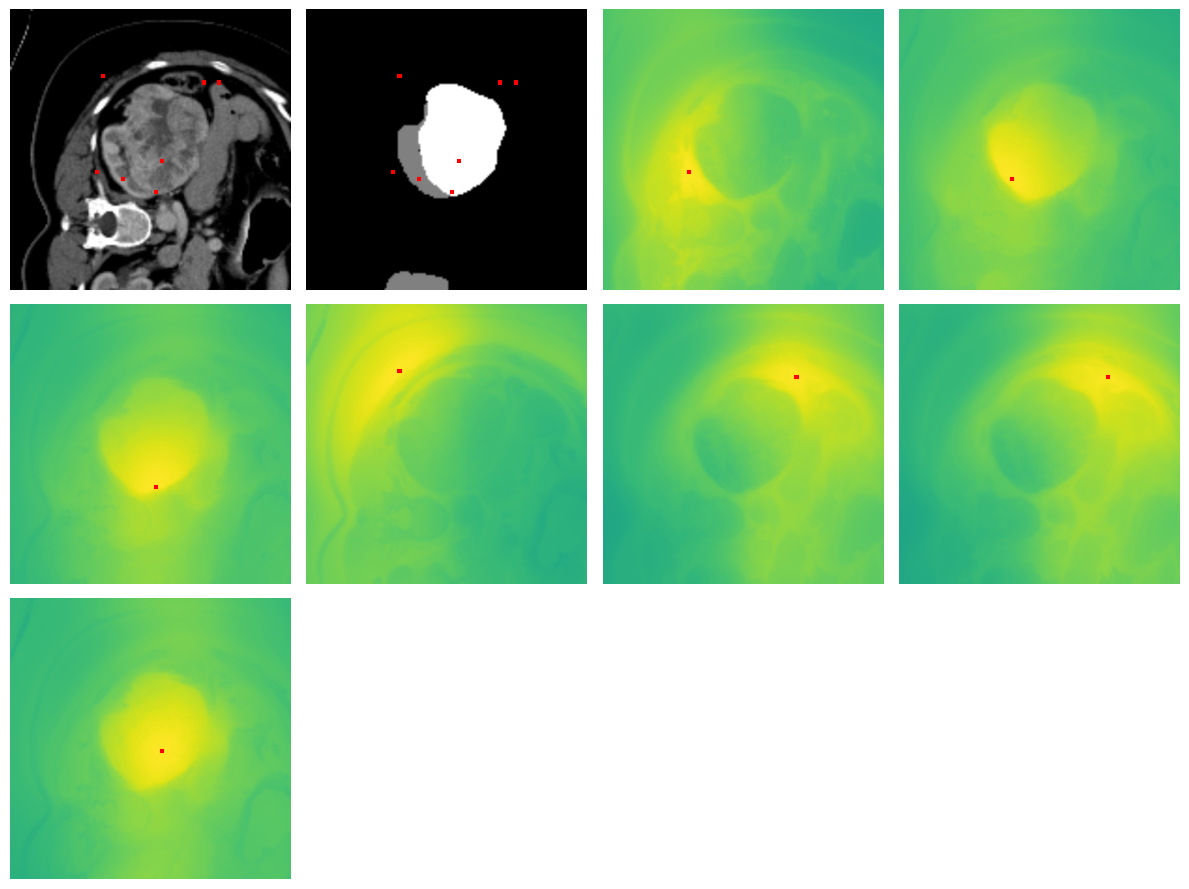

In [26]:
sample = sl_img_r.clone()

plot_patch_similarity_maps(model, sample, size=2048, num_refs=7, refs_per_row=4, seed=0, y1=30, y2=89, x1=30, x2=97)

### Clustering slices

As an additional experiment, to test whether model signal can be used to detect tumor containing slices, inference was run with both models on entire CT cases (every 5th slice to reduce memory). Patches across multiple slices were pooled before running 2D PCA. Patch linear components were plotted, and patch-cluster centroids were calculated and plotted separately. Centroids from slices containing tumor form a distinct region on the plot, observable for both models.

In [11]:
img = torch.tensor(np.load("example_00012_img_wh.npy"))

def slice_to_pil(sl):  # sl: [H,W] float [0,1]
    sl8 = (sl*255).to(torch.uint8).cpu().numpy()
    return Image.fromarray(sl8, "L").convert("RGB")

Z = img.shape[-1]
pil_slices = [slice_to_pil(img[..., z]) for z in range(Z)]

In [12]:
seg = torch.tensor(np.load("example_00012_lab_wh.npy"))

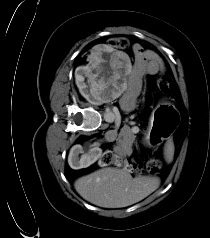

In [15]:
pil_slices[162]

In [6]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vitl16-pretrain-sat493m")
model = AutoModel.from_pretrained("facebook/dinov3-vitl16-pretrain-sat493m", device_map="auto")

In [7]:
BATCH = 5
STRIDE = 5
idxs = list(range(0, len(pil_slices), STRIDE))
feats = []

for s in range(0, len(idxs), BATCH):

    batch_idx = idxs[s:s+BATCH]
    batch = [pil_slices[j] for j in batch_idx]
    
    inputs = processor(
        images=batch,
        return_tensors="pt",
        do_resize=True,
        size={"height": 2048, "width": 2048},
    )
    
    inputs = inputs.to(model.device)
    
    with torch.inference_mode():
        outputs = model(**inputs)
    
    # here are our image embeddings
    # Output shape: [B, 1 + num_register_tokens + num_patches, hidden_size] :contentReference[oaicite:1]{index=1}
    hiddens = outputs.last_hidden_state  # [B, tokens, hidden_dim]
    
    config = model.config
    num_register = config.num_register_tokens
    
    # Discard [CLS] and register tokens, keep patch features
    patch_feats = hiddens[:, 1 + num_register:, :]  # shape: [B, num_patches, hidden_dim]
    feats.append(patch_feats)
    
    del outputs, hiddens, inputs
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
            
    print(f"batch complete")

batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete


In [8]:
X = torch.cat(feats, dim=0).detach().cpu().numpy()

In [27]:
X = torch.tensor(np.load("example_00012_dino_wh.npy")).cpu().numpy()
seg = torch.tensor(np.load("example_00012_lab_wh.npy"))

In [28]:
N, P, D = X.shape
d = 2  # target dims

X2 = X.reshape(-1, D)

In [29]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X2)

In [30]:
pca.explained_variance_ratio_

array([0.34459929, 0.09244441])

In [7]:
idxs = list(range(0, seg.shape[-1], 5))
y_full = ((seg == 2).sum(dim=(0,1)) > 0)
y = y_full[idxs].to(torch.uint8).cpu().numpy()

/tmp/ipykernel_3841/4186595481.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", 20)


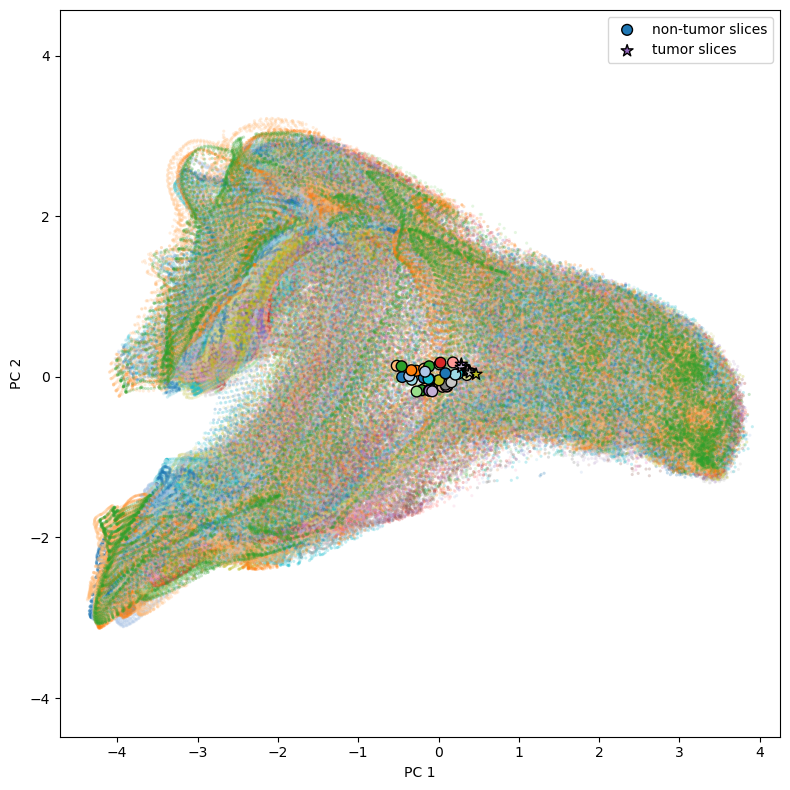

In [54]:
# X: (N, P, D)  ->  X2d: (N*P, 2) from your PCA code
N, P, D = X.shape
slice_ids = np.repeat(np.arange(N), P)          # (N*P,)
X2d = X_2d                                      # from your code

# per-slice tumor label: y ∈ {0,1}, shape (N,)
# e.g., y[z] = 1 if (seg==2).sum((0,1))[z] > 0 else 0

# colors per slice (repeats if N>20)
cmap = plt.cm.get_cmap("tab20", 20)
slice_colors = cmap(np.mod(np.arange(N), 20))
pt_colors = slice_colors[slice_ids]

plt.figure(figsize=(8, 8))
plt.scatter(X2d[:,0], X2d[:,1], s=5, c=pt_colors, alpha=0.25, linewidths=0)

# centroids per slice in 2D
C = X2d.reshape(N, P, 2).mean(axis=1)           # (N,2)

# overlay centroids: tumor vs non-tumor
tum_idx = y.astype(bool)
plt.scatter(C[~tum_idx,0], C[~tum_idx,1], s=60, c=slice_colors[~tum_idx],
            edgecolors="k", marker="o", label="non-tumor slices")
plt.scatter(C[tum_idx,0],  C[tum_idx,1],  s=80, c=slice_colors[tum_idx],
            edgecolors="k", marker="*", label="tumor slices")

plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.axis("equal")
plt.legend(frameon=True)
plt.tight_layout(); plt.show()

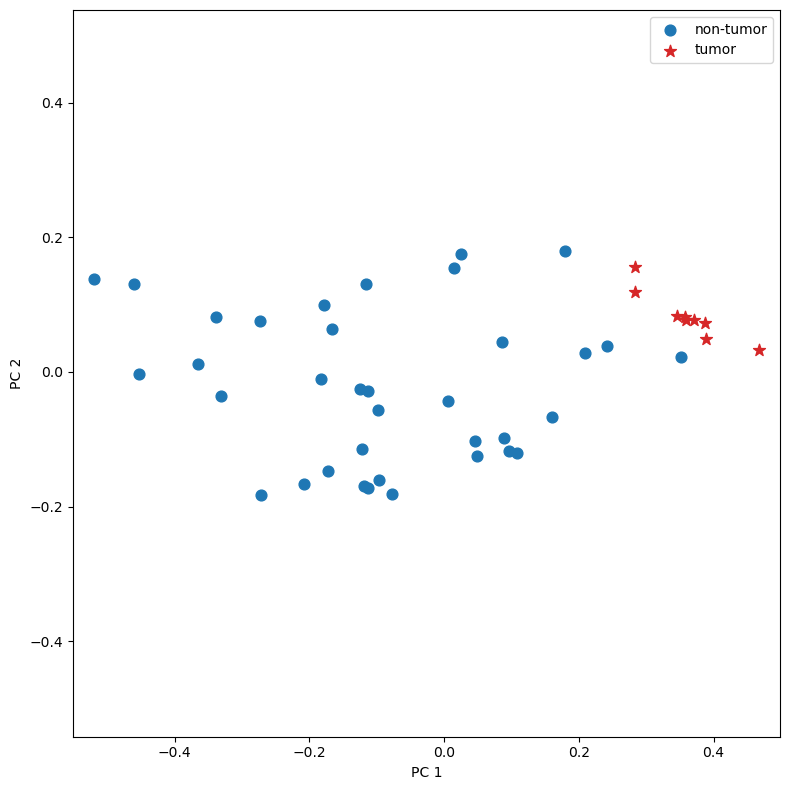

In [55]:
plt.figure(figsize=(8,8))
plt.scatter(C[~tum_idx,0], C[~tum_idx,1], s=60, c="tab:blue",  marker="o", label="non-tumor")
plt.scatter(C[tum_idx,0],  C[tum_idx,1],  s=80, c="tab:red",   marker="*", label="tumor")
plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.axis("equal"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

X_2d = umap_model.fit_transform(X2)

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# X: (N, P, D)  ->  X2d: (N*P, 2) from your PCA code
N, P, D = X.shape
slice_ids = np.repeat(np.arange(N), P)          # (N*P,)
X2d = X_2d                                      # from your code

# per-slice tumor label: y ∈ {0,1}, shape (N,)
# e.g., y[z] = 1 if (seg==2).sum((0,1))[z] > 0 else 0

# colors per slice (repeats if N>20)
cmap = plt.cm.get_cmap("tab20", 20)
slice_colors = cmap(np.mod(np.arange(N), 20))
pt_colors = slice_colors[slice_ids]

plt.figure(figsize=(8, 8))
plt.scatter(X2d[:,0], X2d[:,1], s=5, c=pt_colors, alpha=0.25, linewidths=0)

# centroids per slice in 2D
C = X2d.reshape(N, P, 2).mean(axis=1)           # (N,2)

# overlay centroids: tumor vs non-tumor
tum_idx = y.astype(bool)
plt.scatter(C[~tum_idx,0], C[~tum_idx,1], s=60, c=slice_colors[~tum_idx],
            edgecolors="k", marker="o", label="non-tumor slices")
plt.scatter(C[tum_idx,0],  C[tum_idx,1],  s=80, c=slice_colors[tum_idx],
            edgecolors="k", marker="*", label="tumor slices")

plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.axis("equal")
plt.legend(frameon=True)
plt.tight_layout(); plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[~tum_idx,0], C[~tum_idx,1], s=60, c="tab:blue",  marker="o", label="non-tumor")
plt.scatter(C[tum_idx,0],  C[tum_idx,1],  s=80, c="tab:red",   marker="*", label="tumor")
plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.axis("equal"); plt.legend(); plt.tight_layout(); plt.show()


In [28]:
img = torch.tensor(np.load("example_00479_img_wh.npy"))

Z = img.shape[-1]
slices = [img[..., z] for z in range(Z)]

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sl_img = torch.tensor(slices[0], device=device)
H, W = 2048, 2048
sl_img_r = F.interpolate(sl_img[None, None], size=(H, W), mode="bilinear", align_corners=False)[0,0]
sl_img_r = sl_img_r.repeat(3, 1, 1)

/tmp/ipykernel_148/733701508.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sl_img = torch.tensor(slices[0], device=device)


In [30]:
BATCH = 1
STRIDE = 5
idxs = list(range(0, len(slices), STRIDE))
device = "cuda" if torch.cuda.is_available() else "cpu"
feats = []

for s in range(0, len(idxs), BATCH):

    batch_idx = idxs[s:s+BATCH]
    batch = [slices[j] for j in batch_idx]
    
    sl_img = torch.tensor(batch[0], device=device)
    
    H, W = 2048, 2048
    sl_img_r = F.interpolate(sl_img[None, None], size=(H, W), mode="bilinear", align_corners=False)[0,0]
    sl_img_r = sl_img_r.repeat(3, 1, 1)
    
    inputs = sl_img_r.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(inputs, is_training=True)
    
    # here are our image embeddings
    hiddens = outputs['x_norm_patchtokens']  # [B, tokens, hidden_dim]
    
    feats.append(hiddens)
    
    del outputs, inputs
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
            
    print(f"batch complete")

/tmp/ipykernel_148/4293125468.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sl_img = torch.tensor(batch[0], device=device)


batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete
batch complete


In [31]:
X = torch.cat(feats, dim=0).detach().cpu().numpy()

In [32]:
np.save("example_00479_meddino_wh.npy", X)

In [15]:
N, P, D = X.shape
d = 2  # target dims

X2 = X.reshape(-1, D)

In [16]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X2)

In [17]:
pca.explained_variance_ratio_[:2]

array([0.24767245, 0.16835086], dtype=float32)

In [18]:
seg = torch.tensor(np.load("example_00012_lab_wh.npy"))
idxs = list(range(0, seg.shape[-1], 5))
y_full = ((seg == 2).sum(dim=(0,1)) > 0)
y = y_full[idxs].to(torch.uint8).cpu().numpy()

/tmp/ipykernel_5172/4186595481.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", 20)


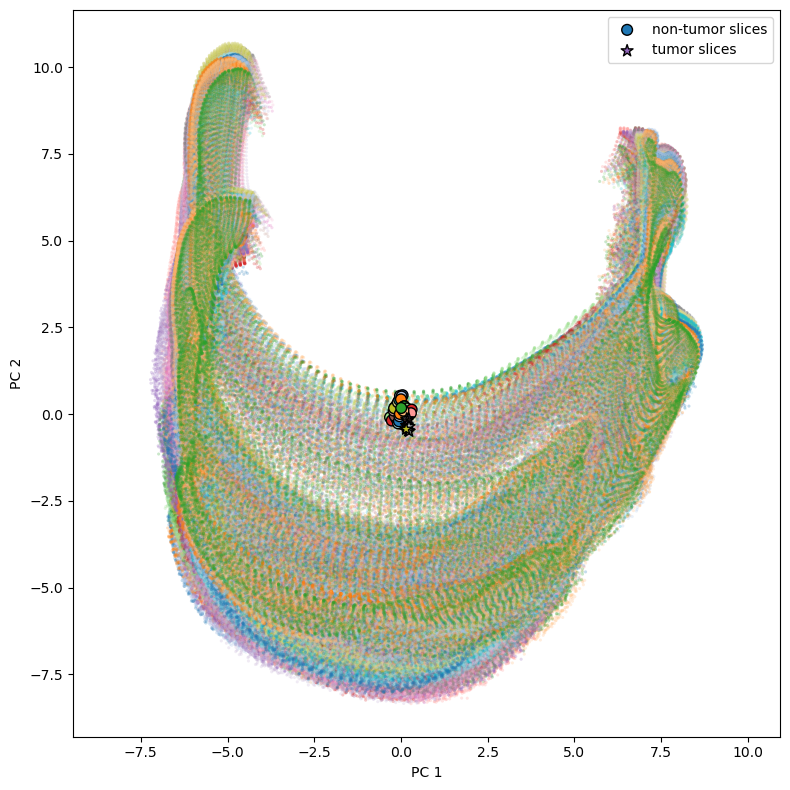

In [19]:
# X: (N, P, D)  ->  X2d: (N*P, 2) from your PCA code
N, P, D = X.shape
slice_ids = np.repeat(np.arange(N), P)          # (N*P,)
X2d = X_2d                                      # from your code

# per-slice tumor label: y ∈ {0,1}, shape (N,)
# e.g., y[z] = 1 if (seg==2).sum((0,1))[z] > 0 else 0

# colors per slice (repeats if N>20)
cmap = plt.cm.get_cmap("tab20", 20)
slice_colors = cmap(np.mod(np.arange(N), 20))
pt_colors = slice_colors[slice_ids]

plt.figure(figsize=(8, 8))
plt.scatter(X2d[:,0], X2d[:,1], s=5, c=pt_colors, alpha=0.25, linewidths=0)

# centroids per slice in 2D
C = X2d.reshape(N, P, 2).mean(axis=1)           # (N,2)

# overlay centroids: tumor vs non-tumor
tum_idx = y.astype(bool)
plt.scatter(C[~tum_idx,0], C[~tum_idx,1], s=60, c=slice_colors[~tum_idx],
            edgecolors="k", marker="o", label="non-tumor slices")
plt.scatter(C[tum_idx,0],  C[tum_idx,1],  s=80, c=slice_colors[tum_idx],
            edgecolors="k", marker="*", label="tumor slices")

plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.axis("equal")
plt.legend(frameon=True)
plt.tight_layout(); plt.show()

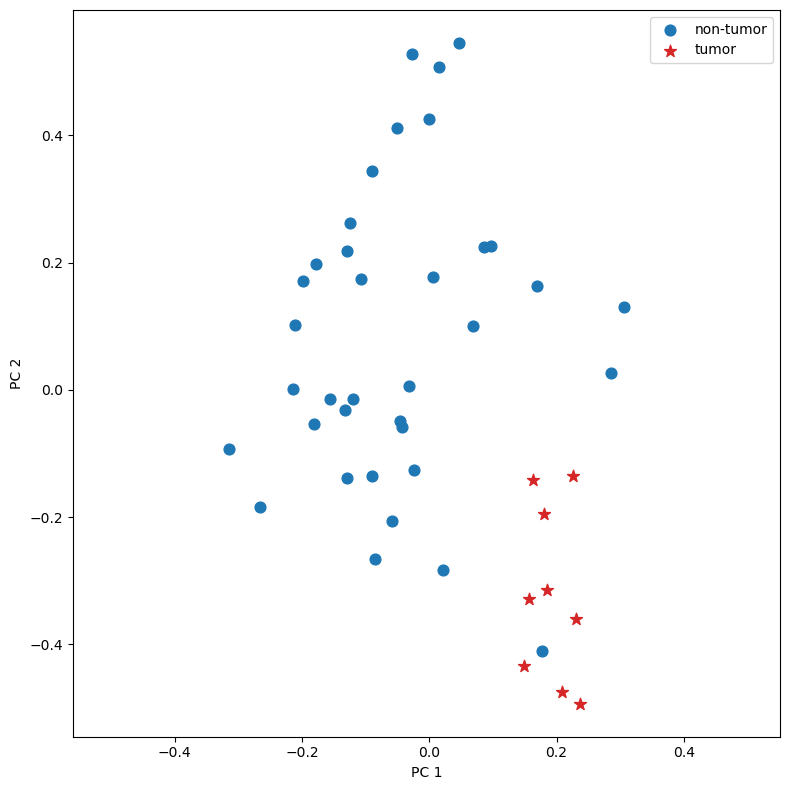

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(C[~tum_idx,0], C[~tum_idx,1], s=60, c="tab:blue",  marker="o", label="non-tumor")
plt.scatter(C[tum_idx,0],  C[tum_idx,1],  s=80, c="tab:red",   marker="*", label="tumor")
plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.axis("equal"); plt.legend(); plt.tight_layout(); plt.show()


### Linear Classification Evaluation

To test whether the features carry tumor-slice signal, a supervised linear classifier (logistic regression) was trained on mean-pooled patch embeddings from the MedDINO model. The train/val split was 60/40 with slices from different cases. Incremental PCA was fit on train slices, then both train and val were reduced to 14 components (≈80% variance per quick checks). For each slice, patches were pooled by simple mean across patches. The classifier was trained and evaluated with ROC-AUC and PR-AUC. The ROC-AUC of 0.576 indicates performance only slightly above random. However, there is room to improve via data preparation, model choice, fine-tuning, alternative pooling, and classifier selection.

In [4]:
train_cases = [
    (np.load("example_00427_meddino_wh.npy"), np.load("example_00427_lab_wh.npy")),
    (np.load("example_00057_meddino_wh.npy"), np.load("example_00057_lab_wh.npy")),
    (np.load("example_00012_meddino_wh.npy"), np.load("example_00012_lab_wh.npy")),
]
val_cases = [
    (np.load("example_00140_meddino_wh.npy"), np.load("example_00140_lab_wh.npy")),
    (np.load("example_00479_meddino_wh.npy"), np.load("example_00479_lab_wh.npy")),
]

In [37]:
def slice_labels(seg):  # tumor present in slice?
    return ((seg == 2).sum(axis=(0,1)) > 0).astype(np.uint8)

d_out = 14 # 80% of variance
batch_size = 2**16
ipca = IncrementalPCA(n_components=d_out, batch_size=batch_size)

print("Starting Incremental PCA fit...")
for X, _ in train_cases:
    Z = X.shape[0]
    print(f"Slices upcoming: {Z}")
    # use all train slices (step=1)
    for z in range(0, Z, 1):
        ipca.partial_fit(X[z])  # X[z]: [P,D]
        if z%5 == 0:
            print(f"{z} completed")
    print("partial finished")
print("---Incremental PCA fit finished---\n")

# --- build TRAIN slice embeddings (mean-pool of PCA-reduced patches)
print("Building train slice emb...")
E_tr, y_tr = [], []
for X, seg in train_cases:
    y = slice_labels(seg)
    Z = X.shape[0]
    print(f"Slices upcoming: {Z}")
    for z in range(0, Z, 1):
        Zp = ipca.transform(X[z])          # [P,d_out]
        e  = Zp.mean(axis=0)               # [d_out]
        E_tr.append(e)
        y_tr.append(int(y[z*5]))
        if z%5 == 0:
            print(f"{z} completed")
    print("partial finished")
E_tr = np.stack(E_tr)                      # [N_tr, d_out]
y_tr = np.array(y_tr)
print("---Building train slice emb finished---\n")

# --- build VAL slice embeddings (every 5th slice, different cases)
print("Building val slice emb...")
E_va, y_va = [], []
for X, seg in val_cases:
    y = slice_labels(seg)
    Z = X.shape[0]
    print(f"Slices upcoming: {Z}")
    for z in range(0, Z, 1):               # step=5
        Zp = ipca.transform(X[z])          # PCA learned on TRAIN
        e  = Zp.mean(axis=0)
        E_va.append(e)
        y_va.append(int(y[z*5]))
        if z%5 == 0:
            print(f"{z} completed")
    print("partial finished")
E_va = np.stack(E_va)
y_va = np.array(y_va)
print("---Building val slice emb finished---\n")

print("Training linear probe clsf...")
clf = LogisticRegression(max_iter=5000, class_weight="balanced", C=1.0, random_state=42)
clf.fit(E_tr, y_tr)
print("---Training finished---\n")

print("Getting stuff together...")
p_va = clf.predict_proba(E_va)[:,1]
roc = roc_auc_score(y_va, p_va)
pr  = average_precision_score(y_va, p_va)
print(f"VAL ROC-AUC: {roc:.3f}  PR-AUC: {pr:.3f}  (d={d_out}, mean-pool)")

Building train slice emb...
Slices upcoming: 24
0 completed
1 completed
2 completed
3 completed
4 completed
5 completed
6 completed
7 completed
8 completed
9 completed
10 completed
11 completed
12 completed
13 completed
14 completed
15 completed
16 completed
17 completed
18 completed
19 completed
20 completed
21 completed
22 completed
23 completed
partial finished
Slices upcoming: 24
0 completed
1 completed
2 completed
3 completed
4 completed
5 completed
6 completed
7 completed
8 completed
9 completed
10 completed
11 completed
12 completed
13 completed
14 completed
15 completed
16 completed
17 completed
18 completed
19 completed
20 completed
21 completed
22 completed
23 completed
partial finished
Slices upcoming: 45
0 completed
1 completed
2 completed
3 completed
4 completed
5 completed
6 completed
7 completed
8 completed
9 completed
10 completed
11 completed
12 completed
13 completed
14 completed
15 completed
16 completed
17 completed
18 completed
19 completed
20 completed
21 complete